# Introduction


Body fat percentage is total mass of fat divided by total body mass. It is an important evaluation of a person's health level, too high or too low might cause diseases. There already some body fat calculators online. However, they usually require too many variables while some of them cannot be obtained easily. In this project, we try to construct a simple, moderately accurate and robust model to predict body fat percentage which obeys the "Rule of Thumb".


The dataset we use contains 252 male observations and 15 useful variables, including "BODYFAT" as response and some others as predictors. We have to construct a linear regression model with this dataset. First we have to clean the raw dataset. Then we fit a model to predict "BODYFAT", in order to obey "Rule of Thumb" we decide to choose two predictors and leave others out. After that, we construct, interpret and diagnose our final model. Finally we conclude the strengths and weaknesses of our final model. 

In [1]:
library(car)
library(leaps)
library(faraway)
library(glmnet)
library(ggplot2)
library(grid)
setwd("C:/Users/Mark Wei/Desktop/628/Project 2")

Loading required package: carData
Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

Attaching package: 'faraway'

The following objects are masked from 'package:car':

    logit, vif

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-18



# Part 1: Dealing with raw data

#### Read in the raw data and do data cleaning (detect and delete the points which bodyfat does not have a linear relationship of 1 / density)

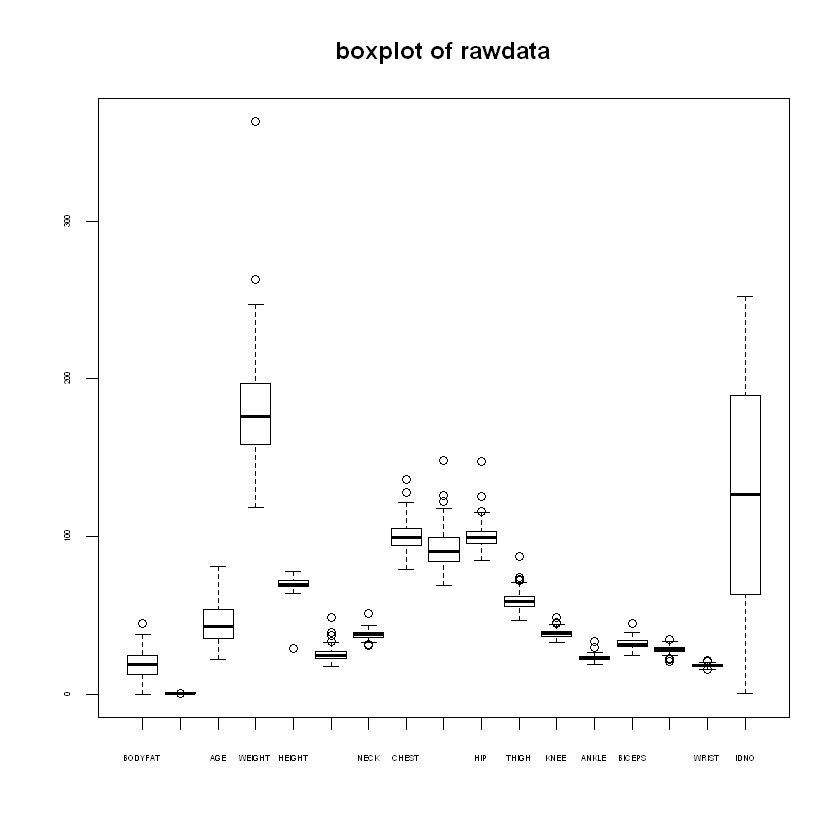

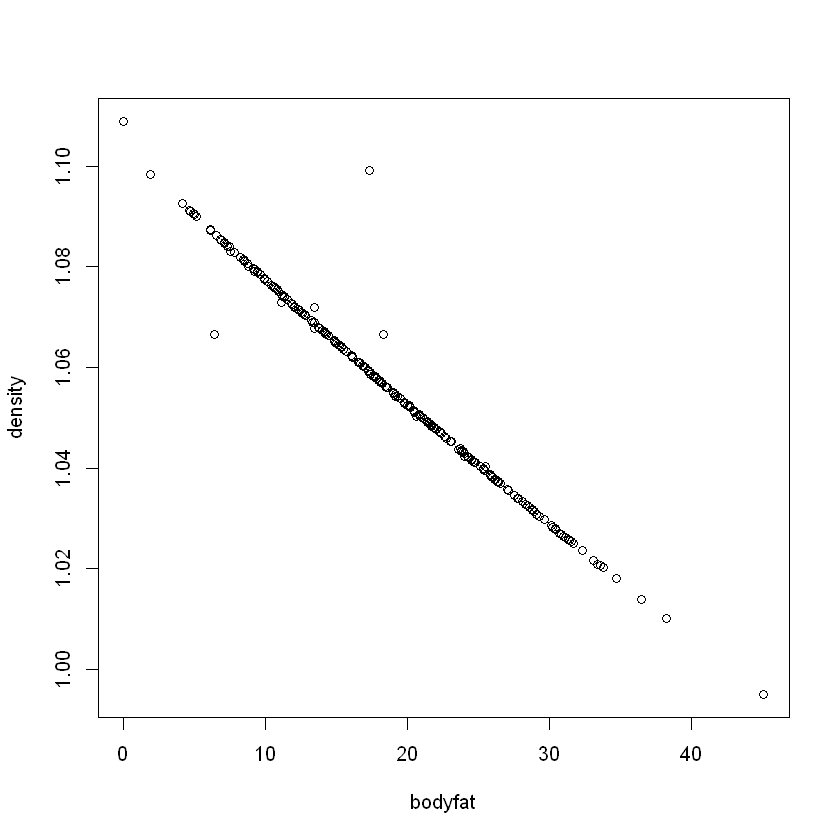

In [2]:
DATA = read.csv("BodyFat.csv", row.names = 1)
data = DATA
data$IDNO = 1:length(data$BODYFAT)
boxplot(data,main="boxplot of rawdata",cex.axis=0.4)      

# data cleaning 
# detect points which bodyfat does not have a linear relationship of 1 / density

plot(data$BODYFAT,data$DENSITY,xlab="bodyfat",ylab="density")
text(1:length(data[,1]), data$BODYFAT, 1:length(data[,1]),cex=0.5)

##########siri##########
####182,48,76,96#######
data$Bodyfat = 495*(1/data$DENSITY)-450
data$sirilabel = ifelse(abs(data$Bodyfat-data$BODYFAT)>sort(abs(data$Bodyfat-data$BODYFAT),decreasing = T)[5],data$IDNO,"")
plot.siri = ggplot(data = data, aes(x =IDNO,y = Bodyfat-BODYFAT, colour = factor(sirilabel)))+ geom_point()+geom_text(data = data,aes(x = IDNO,y = Bodyfat-BODYFAT,label = sirilabel))

##########BMI##########
####163???221???42#####
data$BMI=703*(data$WEIGHT/(data$HEIGHT)^2)
data$bmilabel = ifelse(abs(data$BMI-data$ADIPOSITY)>sort(abs(data$BMI-data$ADIPOSITY),decreasing = T)[4],data$IDNO,"")
plot.bmi = ggplot(data = data, aes(x =IDNO,y = BMI-ADIPOSITY, colour = factor(bmilabel)))+ geom_point()+geom_text(data = data,aes(x = IDNO,y = BMI-ADIPOSITY,label = bmilabel))

#we should get rid of the density 
DATA_new = DATA[, -2]
DATA_new = DATA_new[-c(42, 48, 76, 96, 163, 182, 221),]

In [3]:
########## Before removing the data points with large cook's distance##########
model0 = lm(BODYFAT ~ .,data = DATA[,-2])
data$cook = cooks.distance(model0)
data$cooklabel = ifelse(data$cook>0.02,data$IDNO,"")
plot.cook = ggplot(data = data, aes(x = IDNO, y = cook, colour = factor(cooklabel)))+ geom_point()+ labs(title = "Cook's Distance Before Cleaning") + geom_text(data = data,aes(x = IDNO,y = cook,label = cooklabel))

,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM
39,33.8,1.0202,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0
42,31.7,1.0250,44,205.00,29.50,29.9,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7
48,6.4,1.0665,39,148.50,71.25,20.6,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8
76,18.3,1.0666,61,148.25,67.50,22.9,36.0,91.6,81.8,94.8,54.5,37.0,21.4,29.3,27.0
96,17.3,1.0991,53,224.50,77.75,26.1,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8
163,13.3,1.0690,33,184.25,68.75,24.4,40.7,98.9,92.1,103.5,64.0,37.3,23.5,33.5,30.6
182,0.0,1.1089,40,118.50,68.00,18.1,33.8,79.3,69.4,85.0,47.2,33.5,20.2,27.7,24.6
221,12.7,1.0706,54,153.25,70.50,24.5,38.5,99.0,91.8,96.2,57.7,38.1,23.9,31.4,29.9


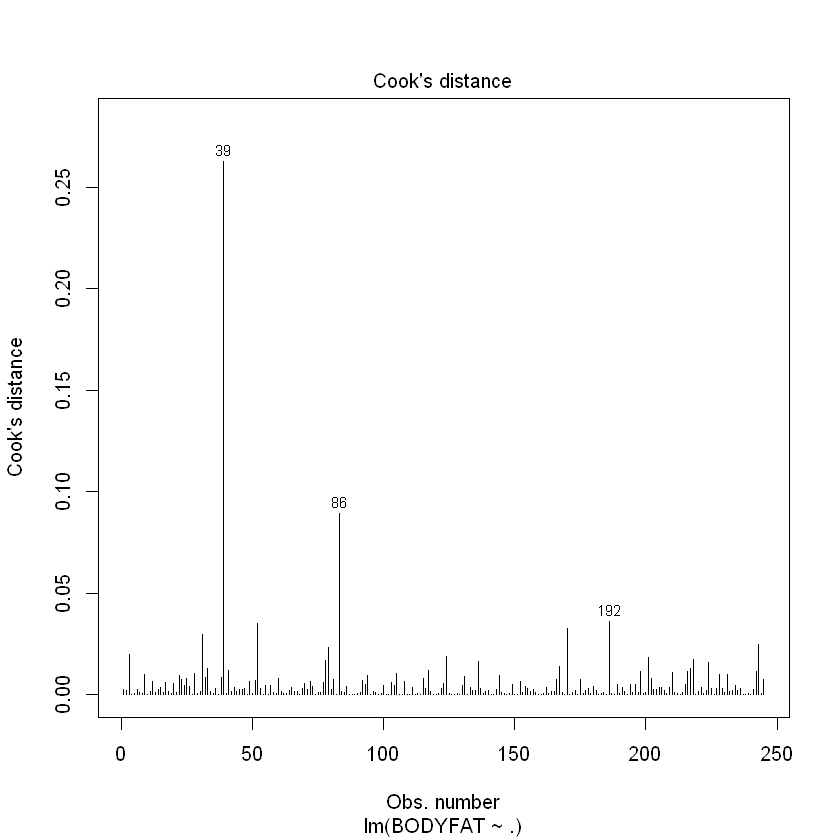

In [4]:
# Check the cook's distance one by one
#########cook###################     
k = 14 ###### number of variables
n = length(DATA$BODYFAT)
index = 1:n
index = index[-c(39,182,48,76,96,163,221,42)]
while(TRUE){
  a = qf(0.5,k,n-k)
  model1<- lm(BODYFAT ~ ., data = DATA_new)
  cook = cooks.distance(model1)
  if(sum(cook>0.5)>0){
    DATA_new = DATA_new[-which.max(cook),]
    index = index[-which.max(cook)]
    n = n-1
  }else{break}
}
out = setdiff(1:length(data$BODYFAT),index)
######cook.distance > F_0.5(k,n-k)####### 

plot(model1, which = 4)
# deleted the possible outliers 39
data[out,1:15]

### By analysis, No.39 has too large weight ; No.42 is too short; No.48, 76, 96, 182 does not match the relationship between bodyfat and density; No.182 also has bodyfat 0 (abnormal value); No.42, 163, 221 don't obey the BMI equation. So we decide to delete eight points: No.39, 42, 48, 76, 96, 163, 182, 221. We remove them and make a new dataset. OutlierTest on the new set does not show any abnormality. Cook's distances also shrink to acceptable values after data cleaning.

In [6]:
data_clean = DATA_new[-39, ]#remove some potential outliers
data_clean = data.frame(scale(data_clean))#scale the data
write.csv(data_clean,"bodyfat_clean.csv",row.names = F)
#check the cook's distance again
model = lm(BODYFAT ~ ., data = data_clean)
#plot(model, which = 4)

#outlier test
outlierTest(model)

No Studentized residuals with Bonferroni p < 0.05
Largest |rstudent|:
     rstudent unadjusted p-value Bonferroni p
224 -2.555635            0.01125           NA

In [7]:
ndata = data[-c(out),]
model10 = lm(BODYFAT ~ .,data = DATA[-c(out),-2])
ndata$cook = cooks.distance(model10)
ndata$cooklabel = ifelse(ndata$cook>0.02,data$IDNO,"")
plot.cook.new = ggplot(data = ndata, aes(x = IDNO, y = cook, colour = factor(cooklabel)))+ geom_point()+labs(title = "Cook's Distance After Cleaning") +geom_text(data = ndata,aes(x = IDNO,y = cook,label = cooklabel))

#### We check new data's Cook's distance again and find nothing weird. The possible outlier No.221 might be caused by randomness. 

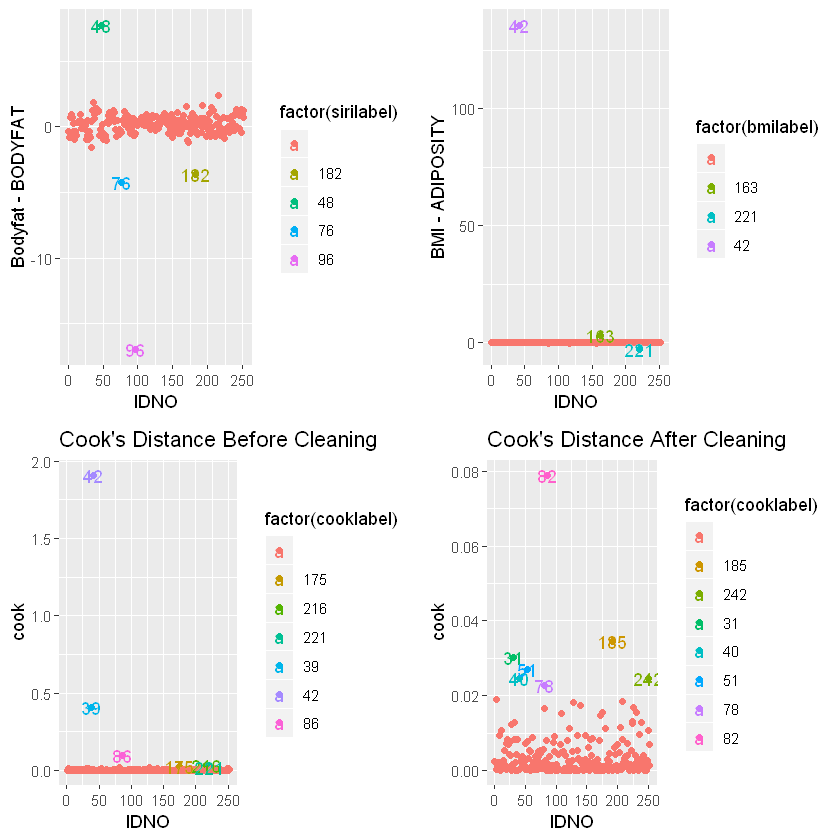

In [8]:
grid.newpage()
pushViewport(viewport(layout = grid.layout(2,2)))

print(plot.siri, vp = viewport(layout.pos.row = 1, layout.pos.col = 1))
print(plot.bmi,  vp = viewport(layout.pos.row = 1, layout.pos.col = 2))
print(plot.cook, vp = viewport(layout.pos.row = 2, layout.pos.col = 1))
print(plot.cook.new, vp = viewport(layout.pos.row = 2, layout.pos.col = 2))
options(repr.plot.width=16, repr.plot.height= 7)

# Part 2: Model selection

#### The methods we use are: AIC, BIC, Mallow's Cp, Adjusted-R^2 and lasso.

In [9]:
full = lm(BODYFAT ~ ., data = data_clean)
base = lm(BODYFAT ~ 1, data = data_clean)

#### 1. AIC (Backward, forward and both sides)

In [10]:
model_AIC_b = step(full, direction = "backward", trace = 0)
print(model_AIC_b)
summary(model_AIC_b)

model_AIC_f = step(base, direction = "forward", trace = 0,scope = list(lower = base, upper = full))
print(model_AIC_f)

model_AIC_t = step(base, direction = "both", trace = 0, scope = list(lower = base, upper = full))
print(model_AIC_t)


Call:
lm(formula = BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + 
    ABDOMEN + HIP + THIGH + FOREARM + WRIST, data = data_clean)

Coefficients:
(Intercept)          AGE       WEIGHT       HEIGHT    ADIPOSITY         NECK  
  1.476e-15    9.644e-02   -1.021e+00    3.811e-01    7.602e-01   -9.918e-02  
    ABDOMEN          HIP        THIGH      FOREARM        WRIST  
  1.076e+00   -1.642e-01    1.701e-01    8.393e-02   -1.678e-01  




Call:
lm(formula = BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + 
    ABDOMEN + HIP + THIGH + FOREARM + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.25248 -0.35972 -0.03786  0.36854  1.20348 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.476e-15  3.276e-02   0.000  1.00000    
AGE          9.644e-02  4.809e-02   2.005  0.04608 *  
WEIGHT      -1.021e+00  4.902e-01  -2.083  0.03831 *  
HEIGHT       3.811e-01  2.435e-01   1.565  0.11896    
ADIPOSITY    7.602e-01  4.288e-01   1.773  0.07755 .  
NECK        -9.918e-02  6.358e-02  -1.560  0.12017    
ABDOMEN      1.076e+00  1.111e-01   9.684  < 2e-16 ***
HIP         -1.642e-01  1.133e-01  -1.449  0.14879    
THIGH        1.701e-01  7.905e-02   2.152  0.03241 *  
FOREARM      8.393e-02  4.880e-02   1.720  0.08680 .  
WRIST       -1.678e-01  5.704e-02  -2.942  0.00359 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standa


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST       BICEPS  
  2.758e-16    1.204e+00   -4.139e-01   -1.477e-01    1.077e-01  


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST       BICEPS  
  2.758e-16    1.204e+00   -4.139e-01   -1.477e-01    1.077e-01  



#### 2. BIC (Backward, forward and both sides)

In [11]:
n = dim(data)[1]
model_BIC_b = step(full, direction = "backward", trace = 0, k = log(n))
print(model_BIC_b)
summary(model_BIC_b)

model_BIC_f = step(base, direction = "forward", trace = 0, scope = list(lower = base, upper = full), k = log(n))
print(model_BIC_f )

model_BIC_t = step(full, direction = "both", trace = 0, k = log(n))
print(model_BIC_t)
summary(model_BIC_t)


Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = data_clean)

Coefficients:
(Intercept)       WEIGHT      ABDOMEN        WRIST  
  2.192e-16   -3.238e-01    1.189e+00   -1.376e-01  




Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.18875 -0.37533 -0.03202  0.38206  1.20597 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.192e-16  3.329e-02   0.000  1.00000    
WEIGHT      -3.238e-01  7.969e-02  -4.063 6.58e-05 ***
ABDOMEN      1.189e+00  6.861e-02  17.329  < 2e-16 ***
WRIST       -1.376e-01  4.878e-02  -2.821  0.00519 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5199 on 240 degrees of freedom
Multiple R-squared:  0.733,	Adjusted R-squared:  0.7297 
F-statistic: 219.6 on 3 and 240 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST, data = data_clean)

Coefficients:
(Intercept)      ABDOMEN       WEIGHT        WRIST  
  2.192e-16    1.189e+00   -3.238e-01   -1.376e-01  


Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = data_clean)

Coefficients:
(Intercept)       WEIGHT      ABDOMEN        WRIST  
  2.192e-16   -3.238e-01    1.189e+00   -1.376e-01  




Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.18875 -0.37533 -0.03202  0.38206  1.20597 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.192e-16  3.329e-02   0.000  1.00000    
WEIGHT      -3.238e-01  7.969e-02  -4.063 6.58e-05 ***
ABDOMEN      1.189e+00  6.861e-02  17.329  < 2e-16 ***
WRIST       -1.376e-01  4.878e-02  -2.821  0.00519 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5199 on 240 degrees of freedom
Multiple R-squared:  0.733,	Adjusted R-squared:  0.7297 
F-statistic: 219.6 on 3 and 240 DF,  p-value: < 2.2e-16


#### 3. Mallow's cp

[1] "AGE"     "HEIGHT"  "CHEST"   "ABDOMEN" "BICEPS"  "WRIST"  



Call:
lm(formula = cp_model, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.26540 -0.37470 -0.02591  0.39018  1.08832 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.855e-16  3.300e-02   0.000  1.00000    
AGE          8.637e-02  3.878e-02   2.227  0.02688 *  
HEIGHT      -1.087e-01  3.887e-02  -2.797  0.00558 ** 
CHEST       -1.837e-01  8.618e-02  -2.132  0.03403 *  
ABDOMEN      1.059e+00  8.091e-02  13.091  < 2e-16 ***
BICEPS       7.786e-02  5.150e-02   1.512  0.13192    
WRIST       -2.017e-01  5.002e-02  -4.032 7.46e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5155 on 237 degrees of freedom
Multiple R-squared:  0.7409,	Adjusted R-squared:  0.7343 
F-statistic: 112.9 on 6 and 237 DF,  p-value: < 2.2e-16


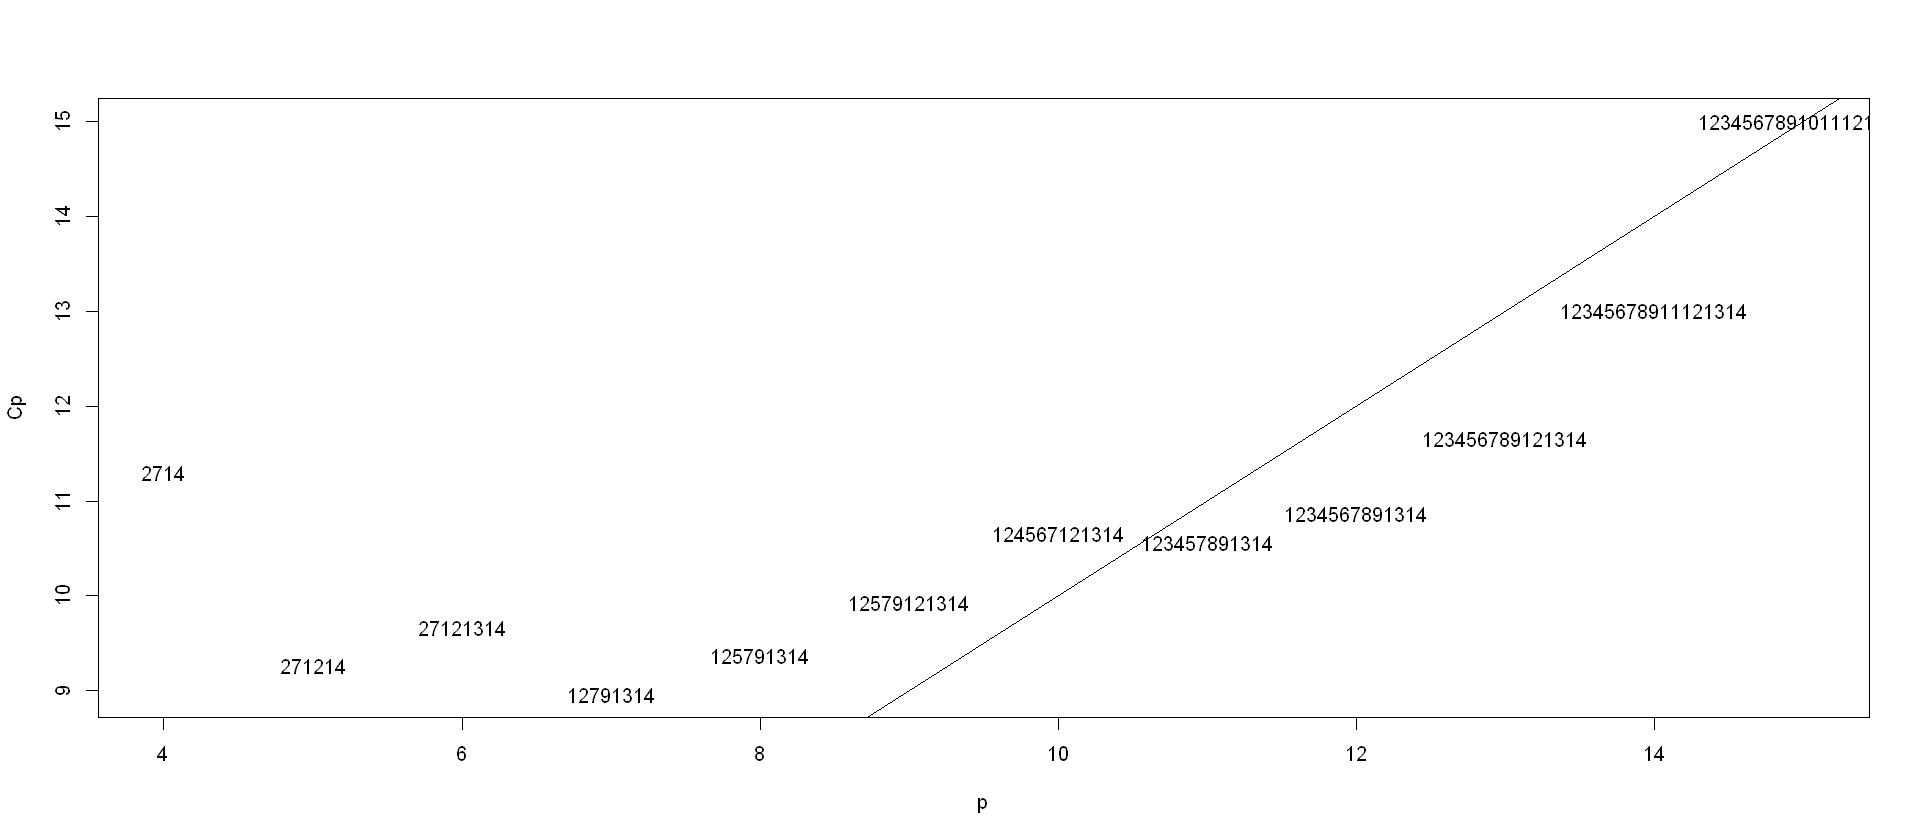

In [12]:
X = data_clean[, -1]
Y = data_clean$BODYFAT
g = leaps(X, Y, nbest = 1)
Cpplot(g)
print(colnames(data_clean)[c(1, 3, 6, 7, 12, 14) + 1])
cp_model = BODYFAT ~ AGE + HEIGHT + CHEST + ABDOMEN +  BICEPS + WRIST
cp_lm = lm(cp_model, data=data_clean)
summary(cp_lm)

#### 4. Adjusted R square

1     2     3     4     5     6     7     8     9     A     B     C     D 
 TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE  TRUE  TRUE 
    E 
 TRUE


Call:
lm(formula = Ad_r, data = data_clean)

Coefficients:
(Intercept)          AGE    ADIPOSITY         NECK        CHEST      ABDOMEN  
  1.671e-17    9.298e-02    2.315e-01   -1.204e-01   -2.341e-01    1.097e+00  
        HIP       BICEPS      FOREARM        WRIST  
 -1.850e-01    6.445e-02    5.945e-02   -2.033e-01  



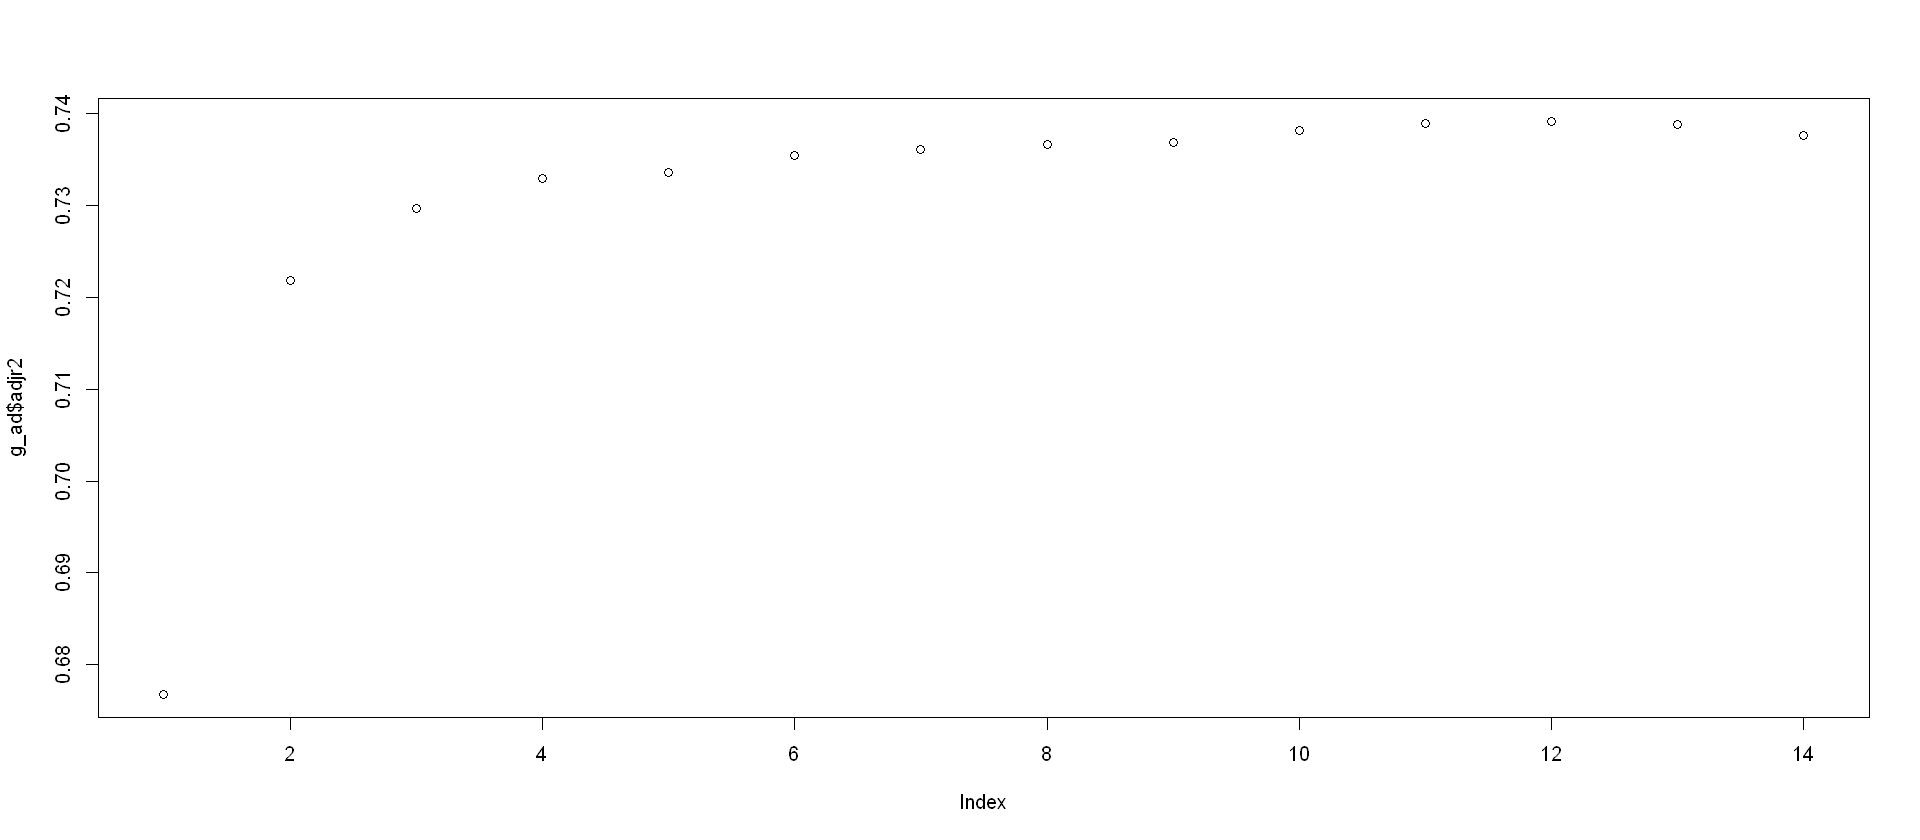

In [13]:
g_ad = leaps(X, Y, nbest = 1,method="adjr2")
plot(g_ad$adjr2)
(g_ad$which)[which(g_ad$adjr2==max(g_ad$adjr2)),]
Ad_r=BODYFAT~AGE+ADIPOSITY+NECK+CHEST+ABDOMEN+HIP+BICEPS+FOREARM+WRIST
adr_model<-lm(Ad_r,data=data_clean)
print(adr_model)

#### 5. Lasso


Call:  glmnet(x = as.matrix(data_clean[, 2:15]), y = data_clean$BODYFAT,      family = "gaussian", alpha = 1, nlambda = 50, standardize = T) 

      Df   %Dev    Lambda
 [1,]  0 0.0000 0.8218000
 [2,]  1 0.2125 0.6809000
 [3,]  1 0.3584 0.5643000
 [4,]  1 0.4586 0.4676000
 [5,]  1 0.5273 0.3875000
 [6,]  1 0.5746 0.3211000
 [7,]  1 0.6070 0.2660000
 [8,]  1 0.6293 0.2205000
 [9,]  1 0.6446 0.1827000
[10,]  2 0.6557 0.1514000
[11,]  2 0.6732 0.1254000
[12,]  2 0.6852 0.1039000
[13,]  3 0.6936 0.0861300
[14,]  4 0.7041 0.0713700
[15,]  4 0.7137 0.0591400
[16,]  4 0.7203 0.0490100
[17,]  4 0.7249 0.0406100
[18,]  4 0.7280 0.0336500
[19,]  5 0.7303 0.0278800
[20,]  5 0.7324 0.0231100
[21,]  7 0.7346 0.0191500
[22,]  7 0.7366 0.0158700
[23,]  9 0.7384 0.0131500
[24,] 10 0.7405 0.0108900
[25,] 11 0.7427 0.0090270
[26,] 11 0.7445 0.0074810
[27,] 11 0.7457 0.0061990
[28,] 12 0.7467 0.0051360
[29,] 13 0.7474 0.0042560
[30,] 13 0.7479 0.0035270
[31,] 14 0.7483 0.0029230
[32,] 14 0.7493 0.002422

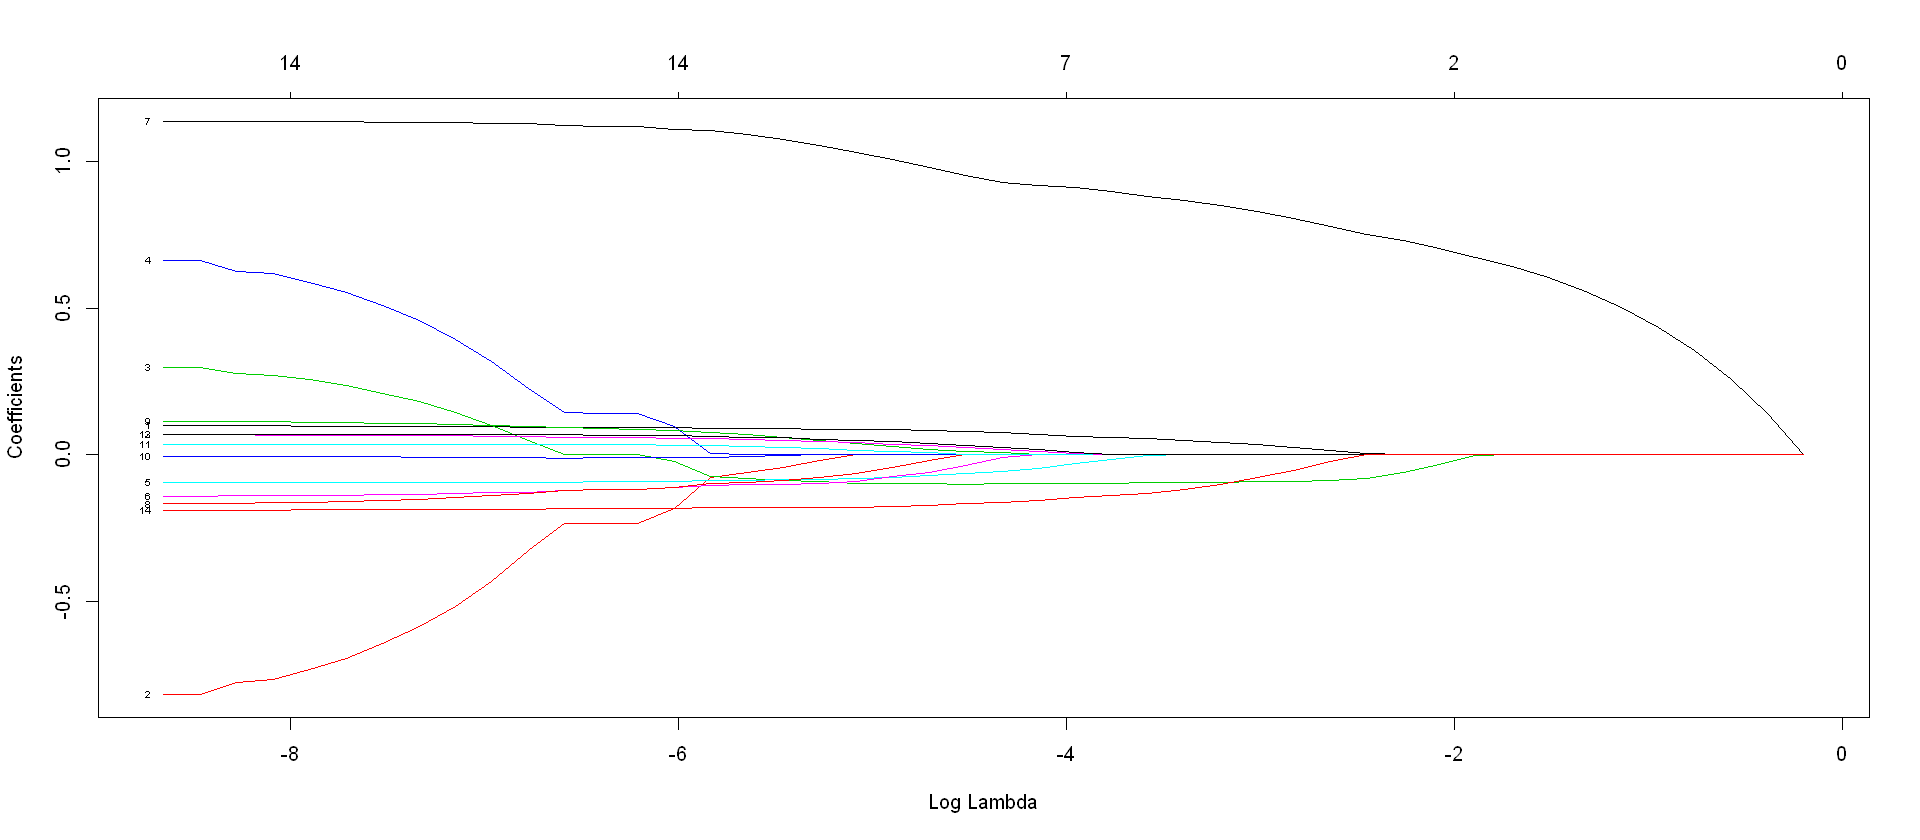

15 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept) -1.166265e-16
AGE          1.779716e-02
WEIGHT       .           
HEIGHT      -8.930600e-02
ADIPOSITY    .           
NECK         .           
CHEST        .           
ABDOMEN      7.884075e-01
HIP          .           
THIGH        .           
KNEE         .           
ANKLE        .           
BICEPS       .           
FOREARM      .           
WRIST       -3.405177e-02

Call:
lm(formula = BODYFAT ~ AGE + HEIGHT + ABDOMEN + WRIST, data = data_clean)

Coefficients:
(Intercept)          AGE       HEIGHT      ABDOMEN        WRIST  
 -2.815e-16    7.994e-02   -1.020e-01    9.444e-01   -2.036e-01  



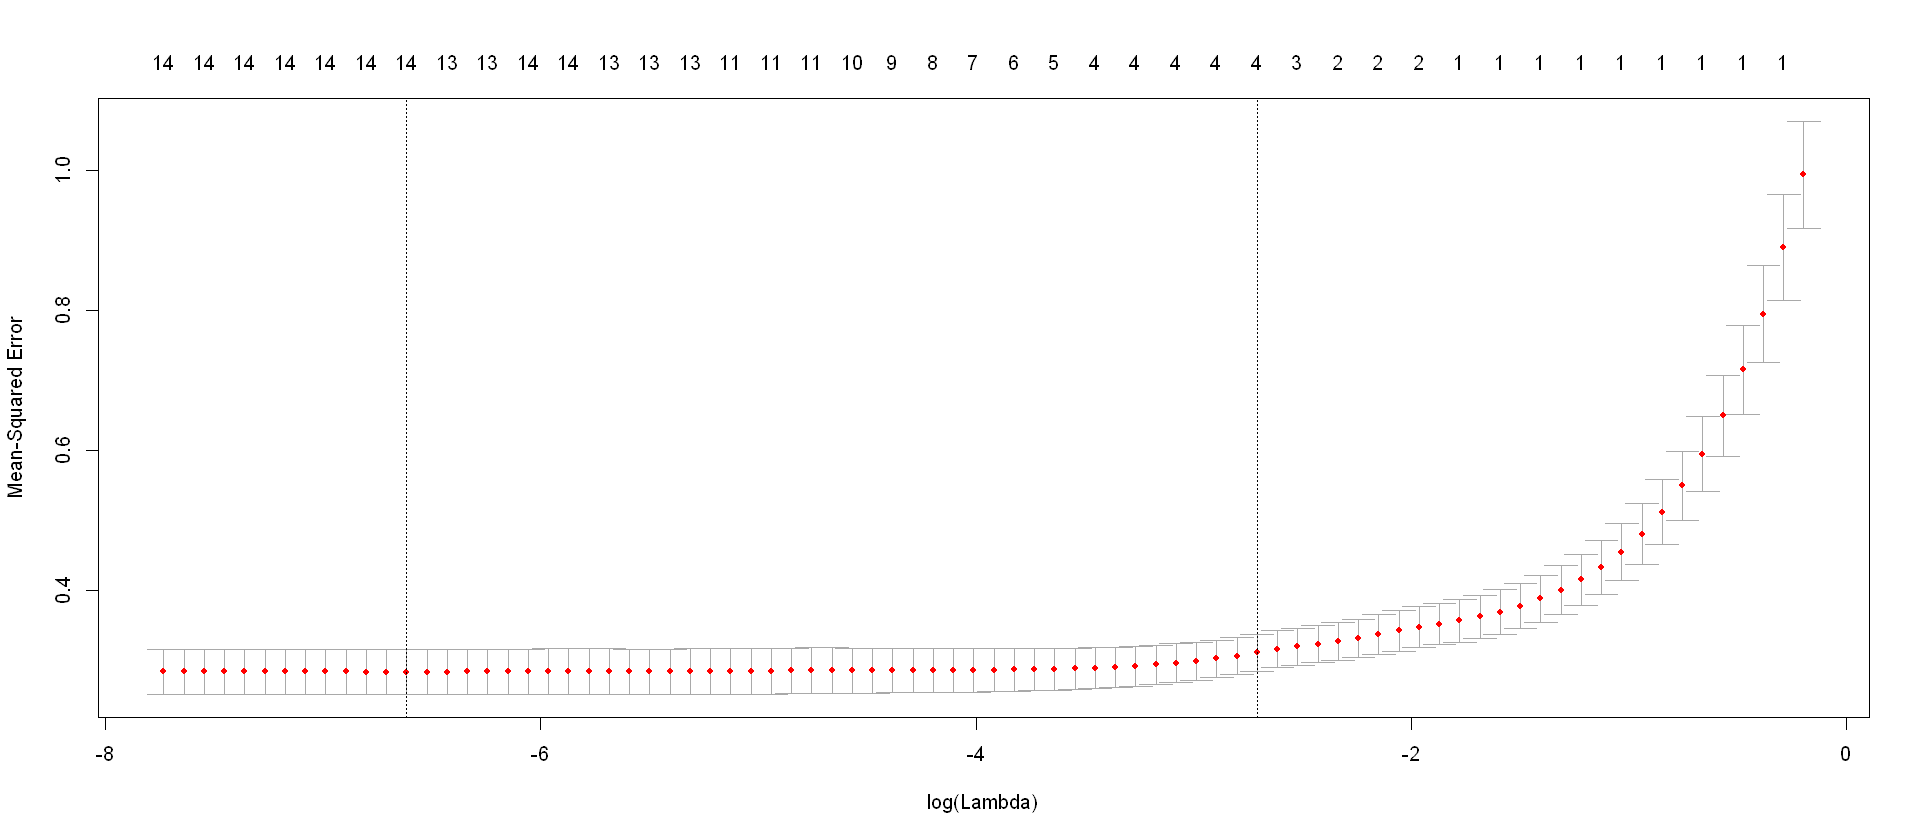

In [14]:
model_l <- glmnet(as.matrix(data_clean[,2:15]), data_clean$BODYFAT, family = "gaussian", nlambda = 50, alpha = 1,standardize = T)
print(model_l)
plot(model_l, xvar = "lambda", label = T)
cvfit <- cv.glmnet(as.matrix(data_clean[,2:15]), data_clean$BODYFAT, family = "gaussian", type.measure = "mse", nfolds = 10,alpha = 1)
plot(cvfit)
print(coef(cvfit, s = "lambda.1se" ))
model_lasso<- BODYFAT ~ AGE + HEIGHT  + ABDOMEN +  WRIST
model_l<-lm(BODYFAT ~ AGE + HEIGHT  + ABDOMEN +  WRIST,data=data_clean)
print(model_l)

# Part3: Other analysis

#### We compare the models above by their summary table and plots.

In [15]:
summary(model_AIC_b)
summary(model_AIC_f)
summary(model_AIC_t)


summary(model_BIC_b)
summary(model_BIC_f)
summary(model_BIC_t)

summary(cp_lm)
summary(adr_model)
summary(model_l)


Call:
lm(formula = BODYFAT ~ AGE + WEIGHT + HEIGHT + ADIPOSITY + NECK + 
    ABDOMEN + HIP + THIGH + FOREARM + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.25248 -0.35972 -0.03786  0.36854  1.20348 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.476e-15  3.276e-02   0.000  1.00000    
AGE          9.644e-02  4.809e-02   2.005  0.04608 *  
WEIGHT      -1.021e+00  4.902e-01  -2.083  0.03831 *  
HEIGHT       3.811e-01  2.435e-01   1.565  0.11896    
ADIPOSITY    7.602e-01  4.288e-01   1.773  0.07755 .  
NECK        -9.918e-02  6.358e-02  -1.560  0.12017    
ABDOMEN      1.076e+00  1.111e-01   9.684  < 2e-16 ***
HIP         -1.642e-01  1.133e-01  -1.449  0.14879    
THIGH        1.701e-01  7.905e-02   2.152  0.03241 *  
FOREARM      8.393e-02  4.880e-02   1.720  0.08680 .  
WRIST       -1.678e-01  5.704e-02  -2.942  0.00359 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standa


Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.23562 -0.36528 -0.01922  0.39216  1.12071 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.758e-16  3.308e-02   0.000  1.00000    
ABDOMEN      1.204e+00  6.860e-02  17.549  < 2e-16 ***
WEIGHT      -4.139e-01  9.123e-02  -4.536 9.07e-06 ***
WRIST       -1.477e-01  4.875e-02  -3.029  0.00272 ** 
BICEPS       1.077e-01  5.412e-02   1.990  0.04774 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5168 on 239 degrees of freedom
Multiple R-squared:  0.7373,	Adjusted R-squared:  0.7329 
F-statistic: 167.7 on 4 and 239 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST + BICEPS, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.23562 -0.36528 -0.01922  0.39216  1.12071 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.758e-16  3.308e-02   0.000  1.00000    
ABDOMEN      1.204e+00  6.860e-02  17.549  < 2e-16 ***
WEIGHT      -4.139e-01  9.123e-02  -4.536 9.07e-06 ***
WRIST       -1.477e-01  4.875e-02  -3.029  0.00272 ** 
BICEPS       1.077e-01  5.412e-02   1.990  0.04774 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5168 on 239 degrees of freedom
Multiple R-squared:  0.7373,	Adjusted R-squared:  0.7329 
F-statistic: 167.7 on 4 and 239 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.18875 -0.37533 -0.03202  0.38206  1.20597 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.192e-16  3.329e-02   0.000  1.00000    
WEIGHT      -3.238e-01  7.969e-02  -4.063 6.58e-05 ***
ABDOMEN      1.189e+00  6.861e-02  17.329  < 2e-16 ***
WRIST       -1.376e-01  4.878e-02  -2.821  0.00519 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5199 on 240 degrees of freedom
Multiple R-squared:  0.733,	Adjusted R-squared:  0.7297 
F-statistic: 219.6 on 3 and 240 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.18875 -0.37533 -0.03202  0.38206  1.20597 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.192e-16  3.329e-02   0.000  1.00000    
ABDOMEN      1.189e+00  6.861e-02  17.329  < 2e-16 ***
WEIGHT      -3.238e-01  7.969e-02  -4.063 6.58e-05 ***
WRIST       -1.376e-01  4.878e-02  -2.821  0.00519 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5199 on 240 degrees of freedom
Multiple R-squared:  0.733,	Adjusted R-squared:  0.7297 
F-statistic: 219.6 on 3 and 240 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ WEIGHT + ABDOMEN + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.18875 -0.37533 -0.03202  0.38206  1.20597 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.192e-16  3.329e-02   0.000  1.00000    
WEIGHT      -3.238e-01  7.969e-02  -4.063 6.58e-05 ***
ABDOMEN      1.189e+00  6.861e-02  17.329  < 2e-16 ***
WRIST       -1.376e-01  4.878e-02  -2.821  0.00519 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5199 on 240 degrees of freedom
Multiple R-squared:  0.733,	Adjusted R-squared:  0.7297 
F-statistic: 219.6 on 3 and 240 DF,  p-value: < 2.2e-16



Call:
lm(formula = cp_model, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.26540 -0.37470 -0.02591  0.39018  1.08832 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.855e-16  3.300e-02   0.000  1.00000    
AGE          8.637e-02  3.878e-02   2.227  0.02688 *  
HEIGHT      -1.087e-01  3.887e-02  -2.797  0.00558 ** 
CHEST       -1.837e-01  8.618e-02  -2.132  0.03403 *  
ABDOMEN      1.059e+00  8.091e-02  13.091  < 2e-16 ***
BICEPS       7.786e-02  5.150e-02   1.512  0.13192    
WRIST       -2.017e-01  5.002e-02  -4.032 7.46e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5155 on 237 degrees of freedom
Multiple R-squared:  0.7409,	Adjusted R-squared:  0.7343 
F-statistic: 112.9 on 6 and 237 DF,  p-value: < 2.2e-16



Call:
lm(formula = Ad_r, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.26763 -0.36712 -0.04028  0.37972  1.20616 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.671e-17  3.287e-02   0.000 1.000000    
AGE          9.298e-02  4.355e-02   2.135 0.033810 *  
ADIPOSITY    2.315e-01  1.012e-01   2.288 0.023003 *  
NECK        -1.204e-01  6.169e-02  -1.952 0.052139 .  
CHEST       -2.341e-01  9.500e-02  -2.464 0.014460 *  
ABDOMEN      1.097e+00  1.103e-01   9.950  < 2e-16 ***
HIP         -1.850e-01  8.513e-02  -2.174 0.030737 *  
BICEPS       6.445e-02  5.741e-02   1.123 0.262684    
FOREARM      5.945e-02  5.036e-02   1.180 0.239071    
WRIST       -2.033e-01  5.344e-02  -3.804 0.000181 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5135 on 234 degrees of freedom
Multiple R-squared:  0.7461,	Adjusted R-squared:  0.7363 
F-statistic:  76.4 on 9 and 234 DF,  p-value: <


Call:
lm(formula = BODYFAT ~ AGE + HEIGHT + ABDOMEN + WRIST, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.25508 -0.37499 -0.03633  0.39655  1.14166 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.815e-16  3.324e-02   0.000  1.00000    
AGE          7.994e-02  3.722e-02   2.148  0.03272 *  
HEIGHT      -1.020e-01  3.905e-02  -2.612  0.00958 ** 
ABDOMEN      9.444e-01  4.223e-02  22.361  < 2e-16 ***
WRIST       -2.036e-01  4.591e-02  -4.434 1.41e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5193 on 239 degrees of freedom
Multiple R-squared:  0.7348,	Adjusted R-squared:  0.7304 
F-statistic: 165.5 on 4 and 239 DF,  p-value: < 2.2e-16


## Diagnostic plot

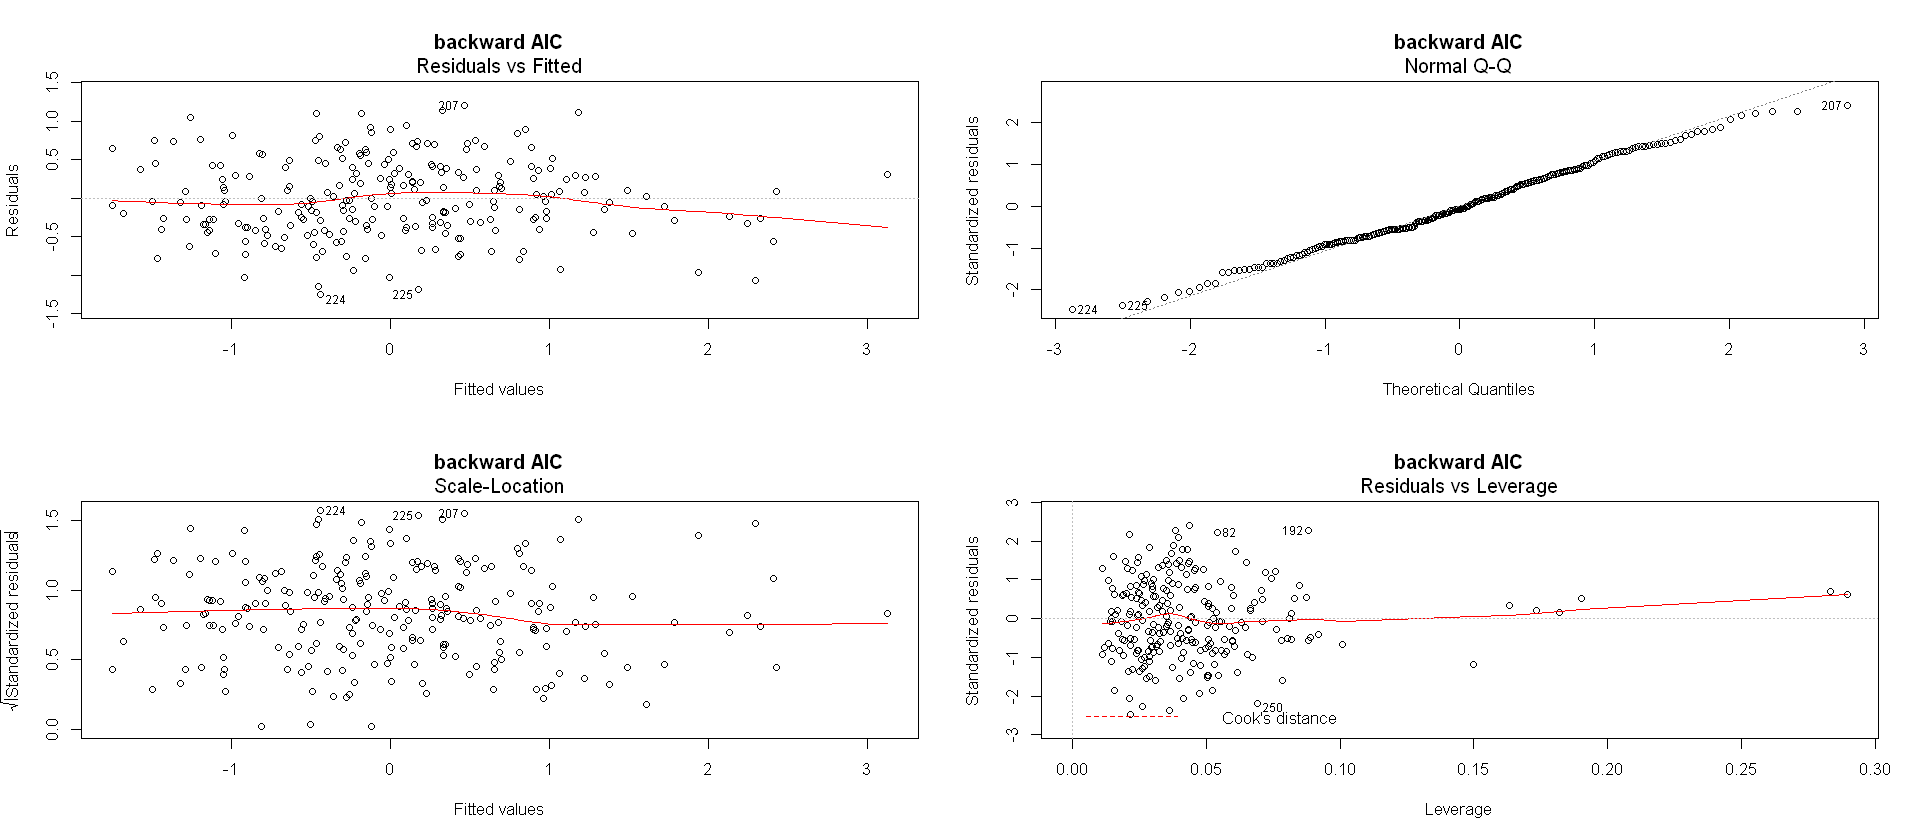

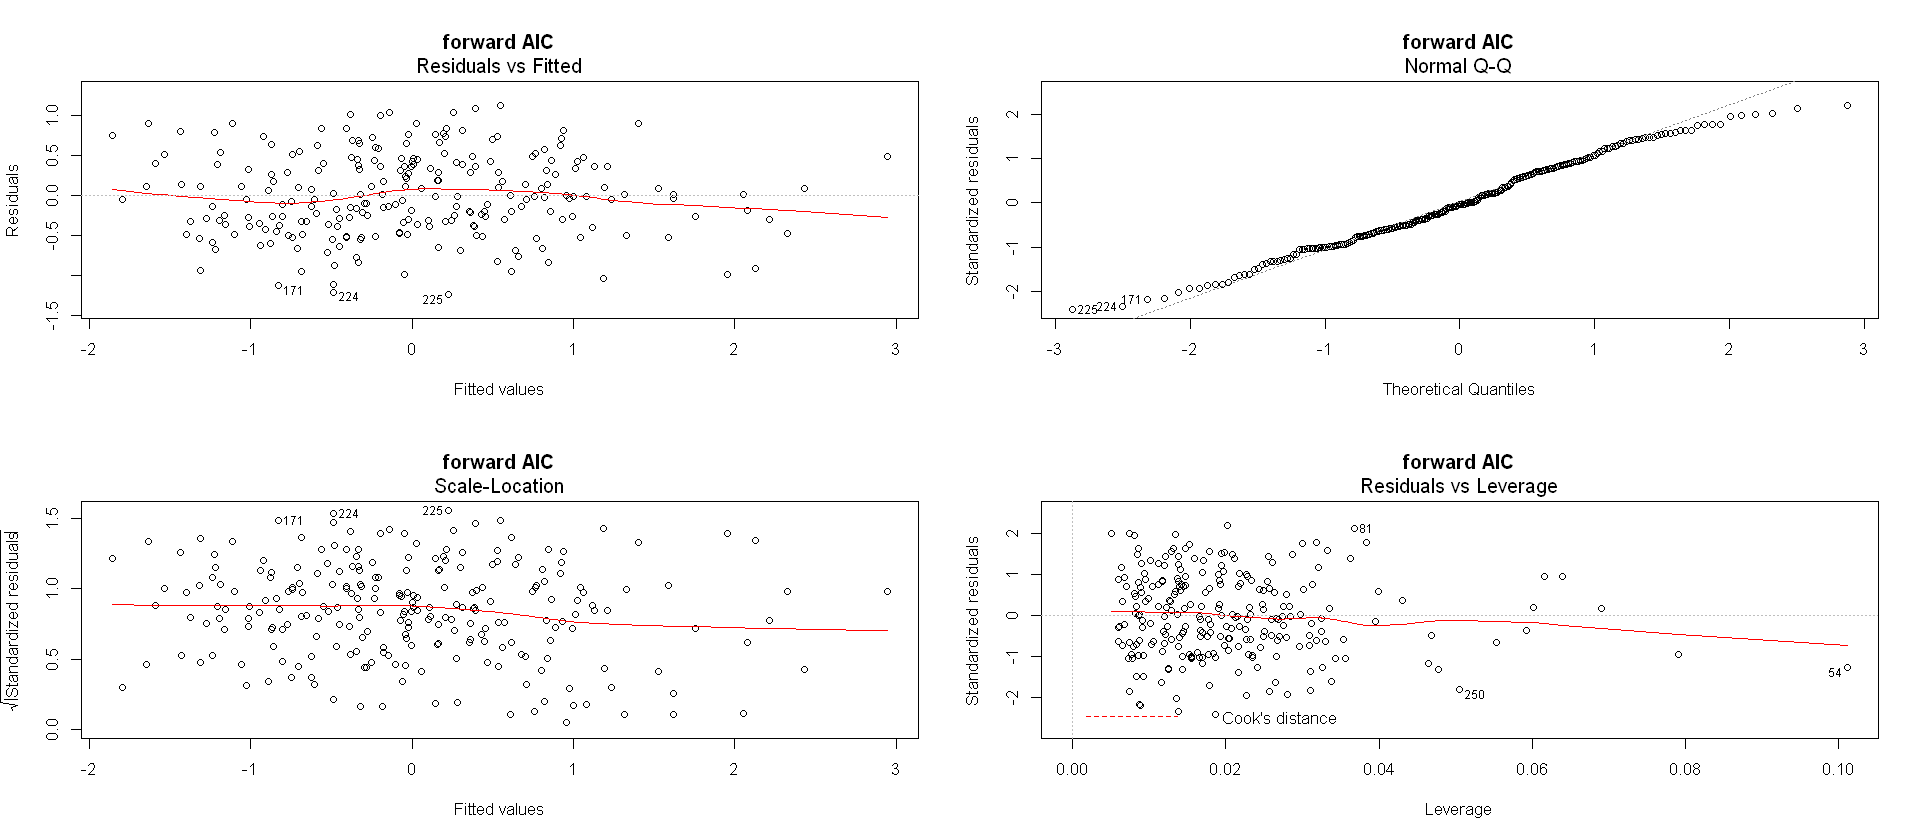

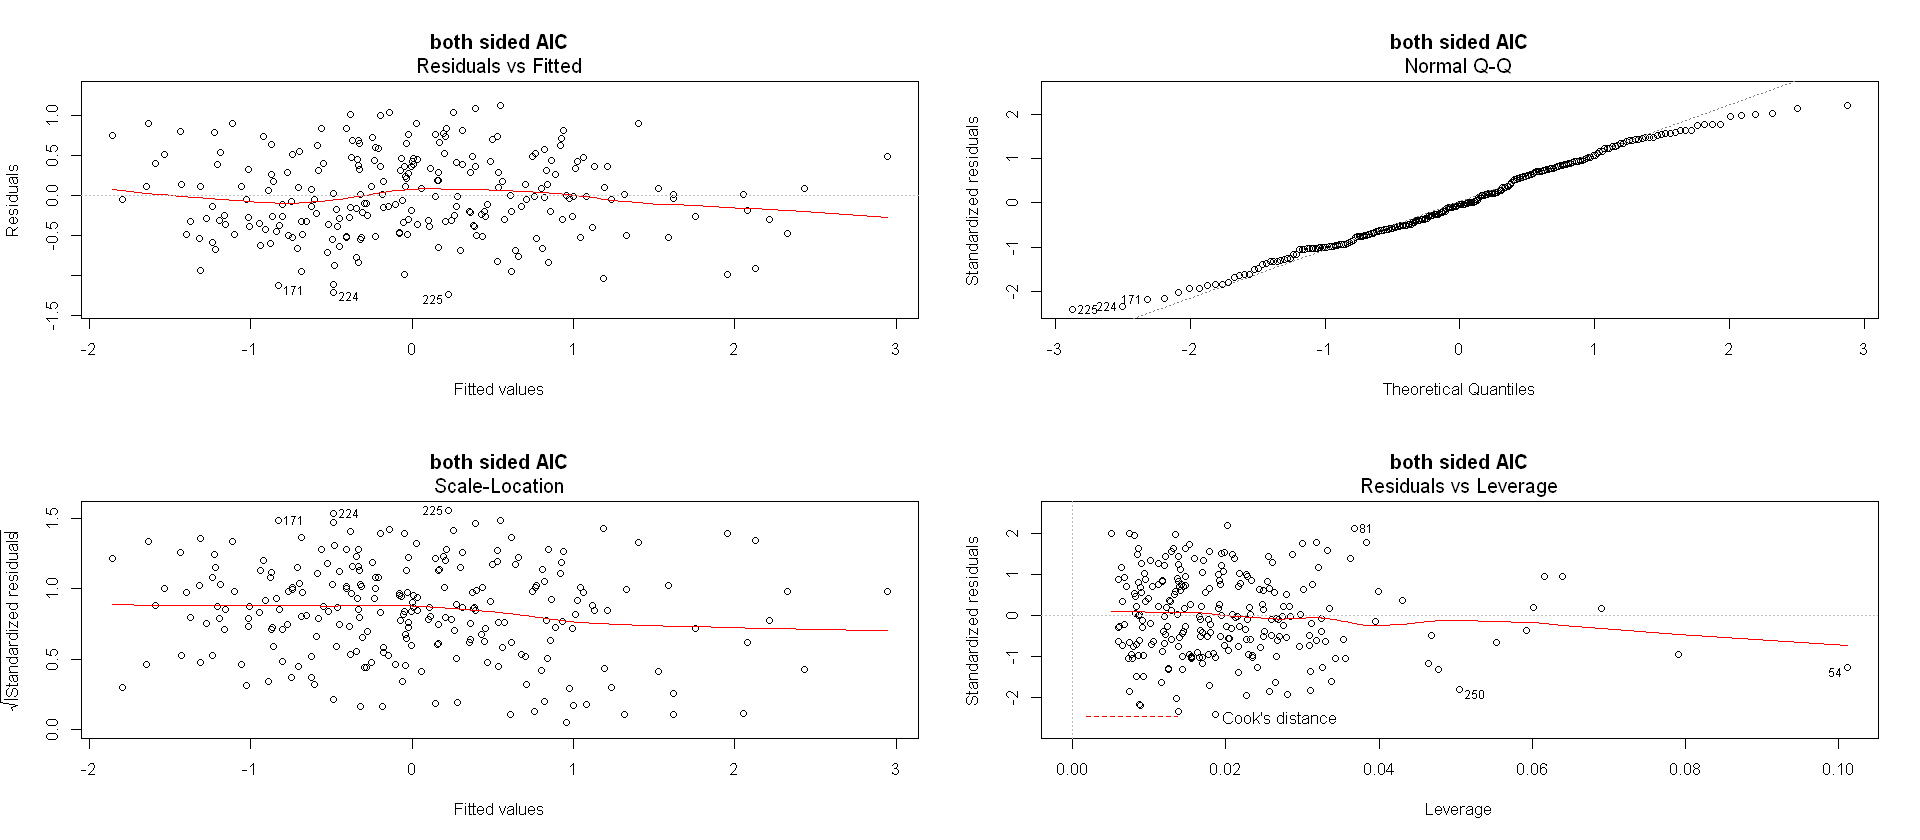

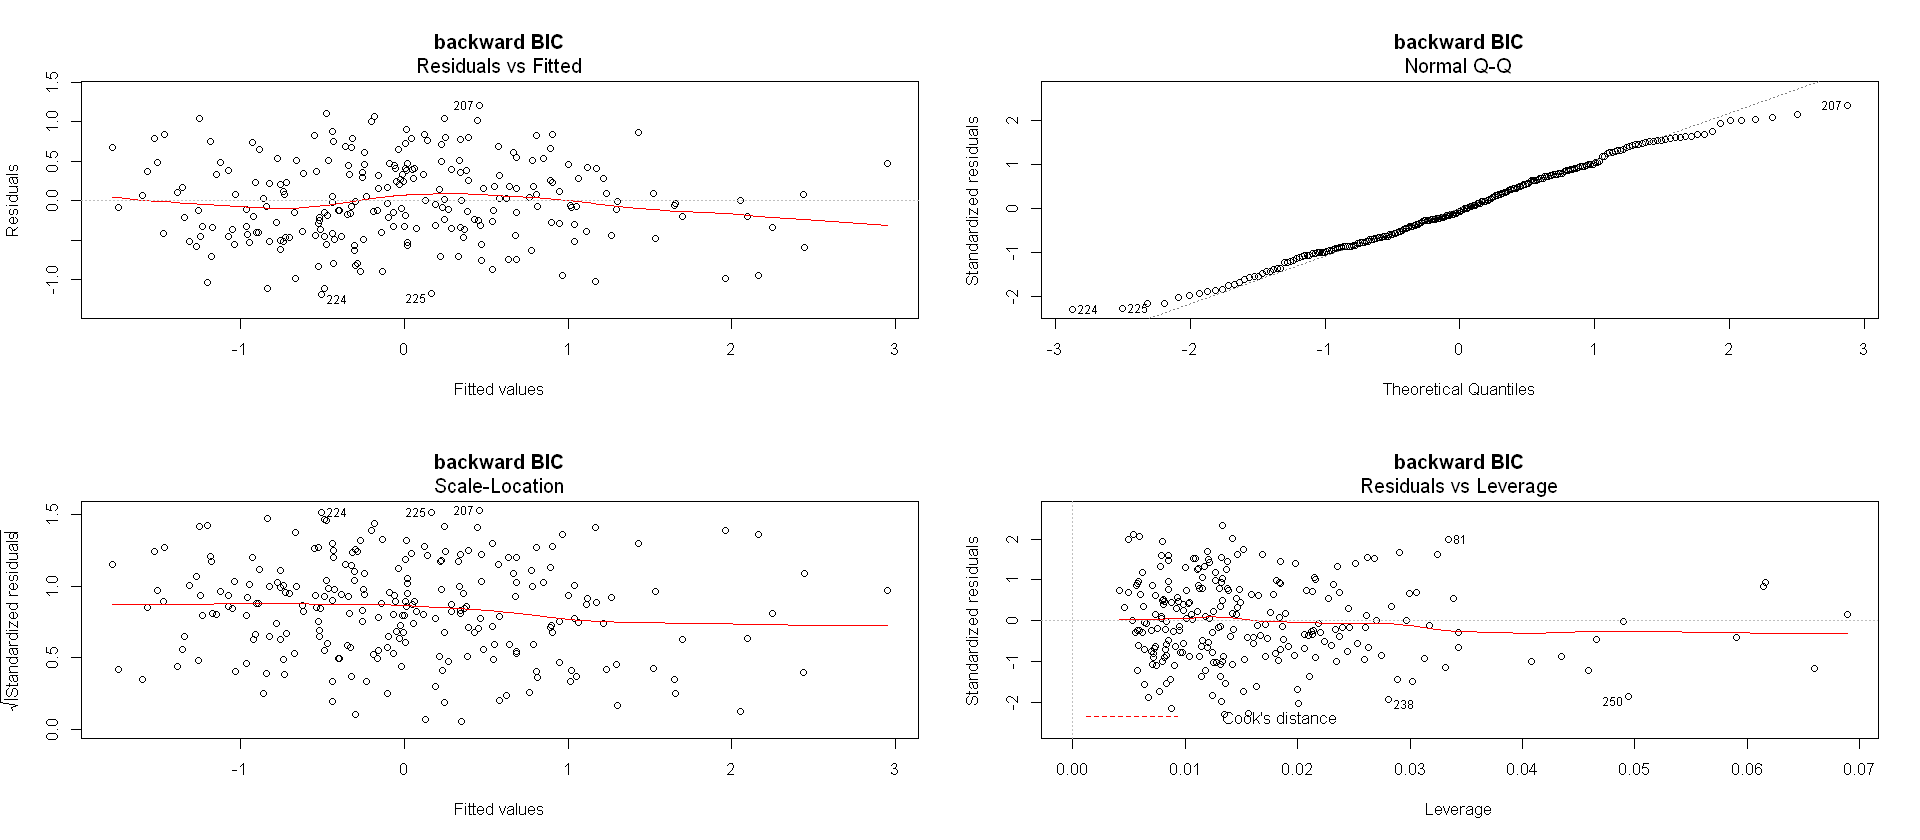

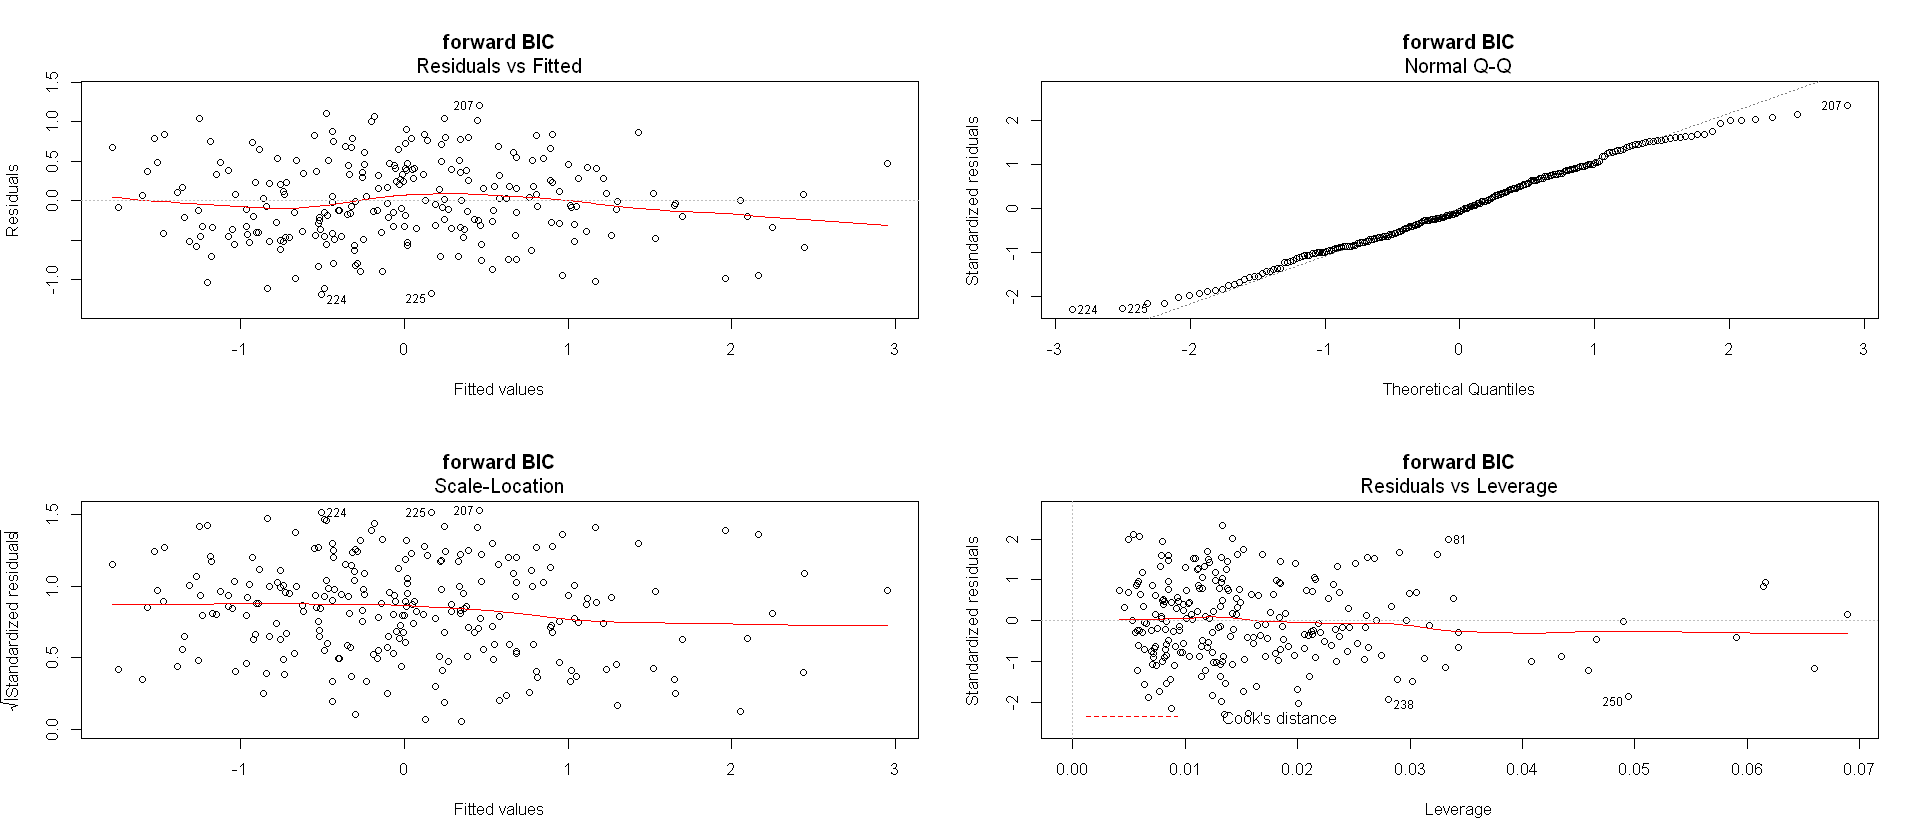

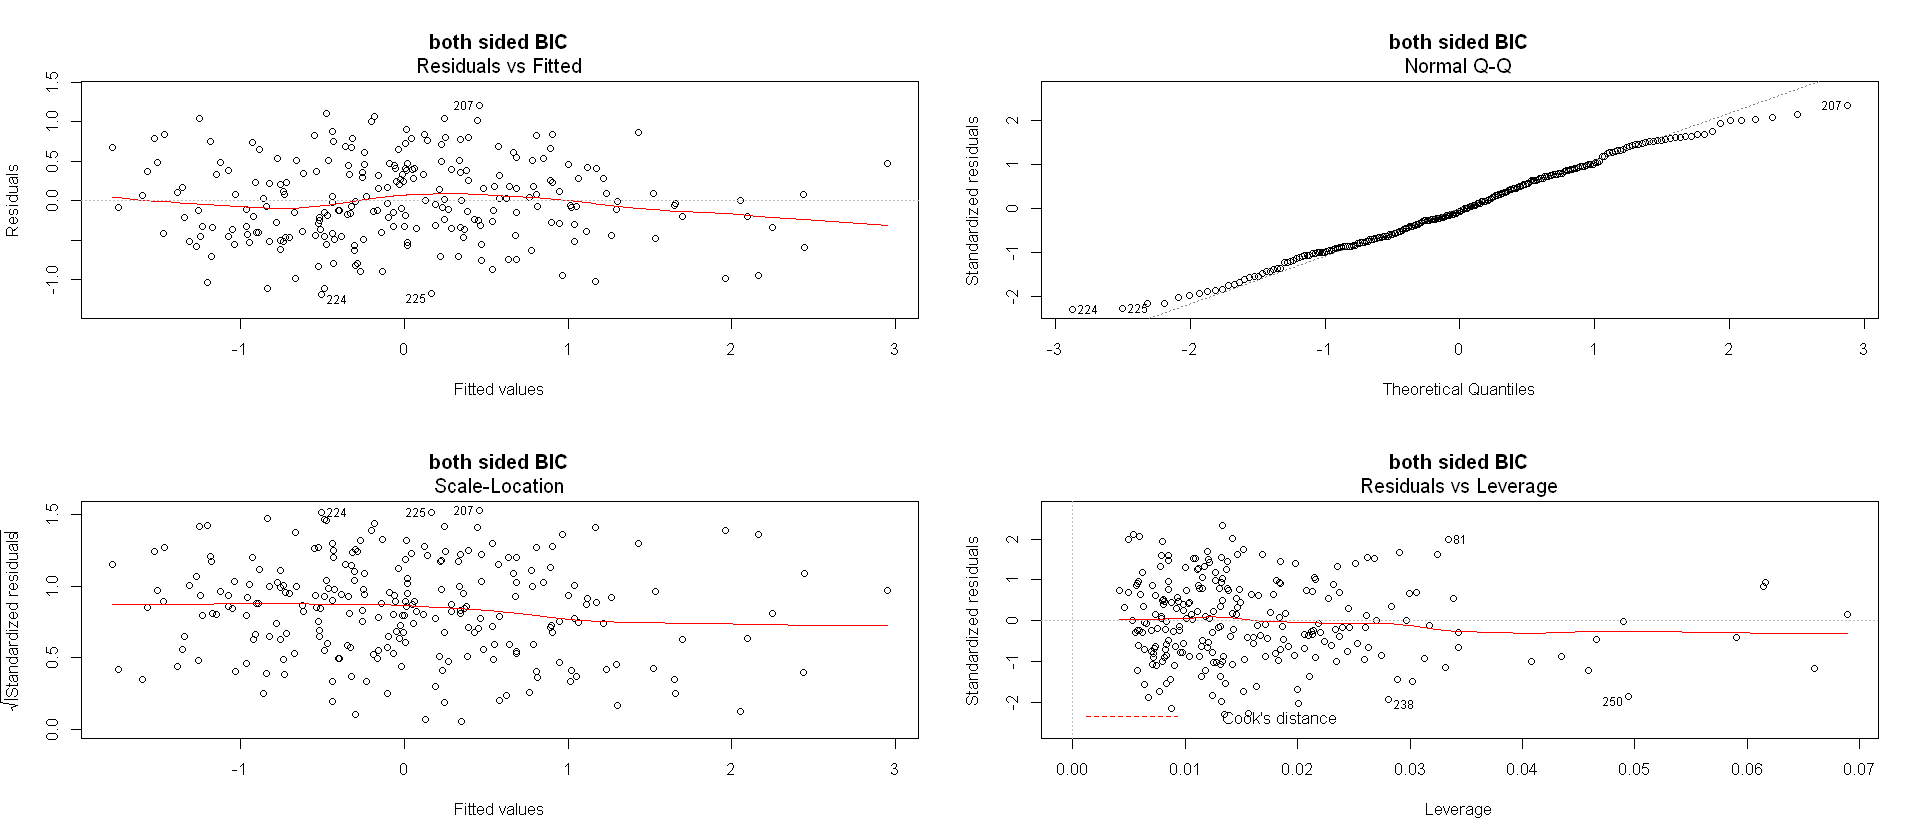

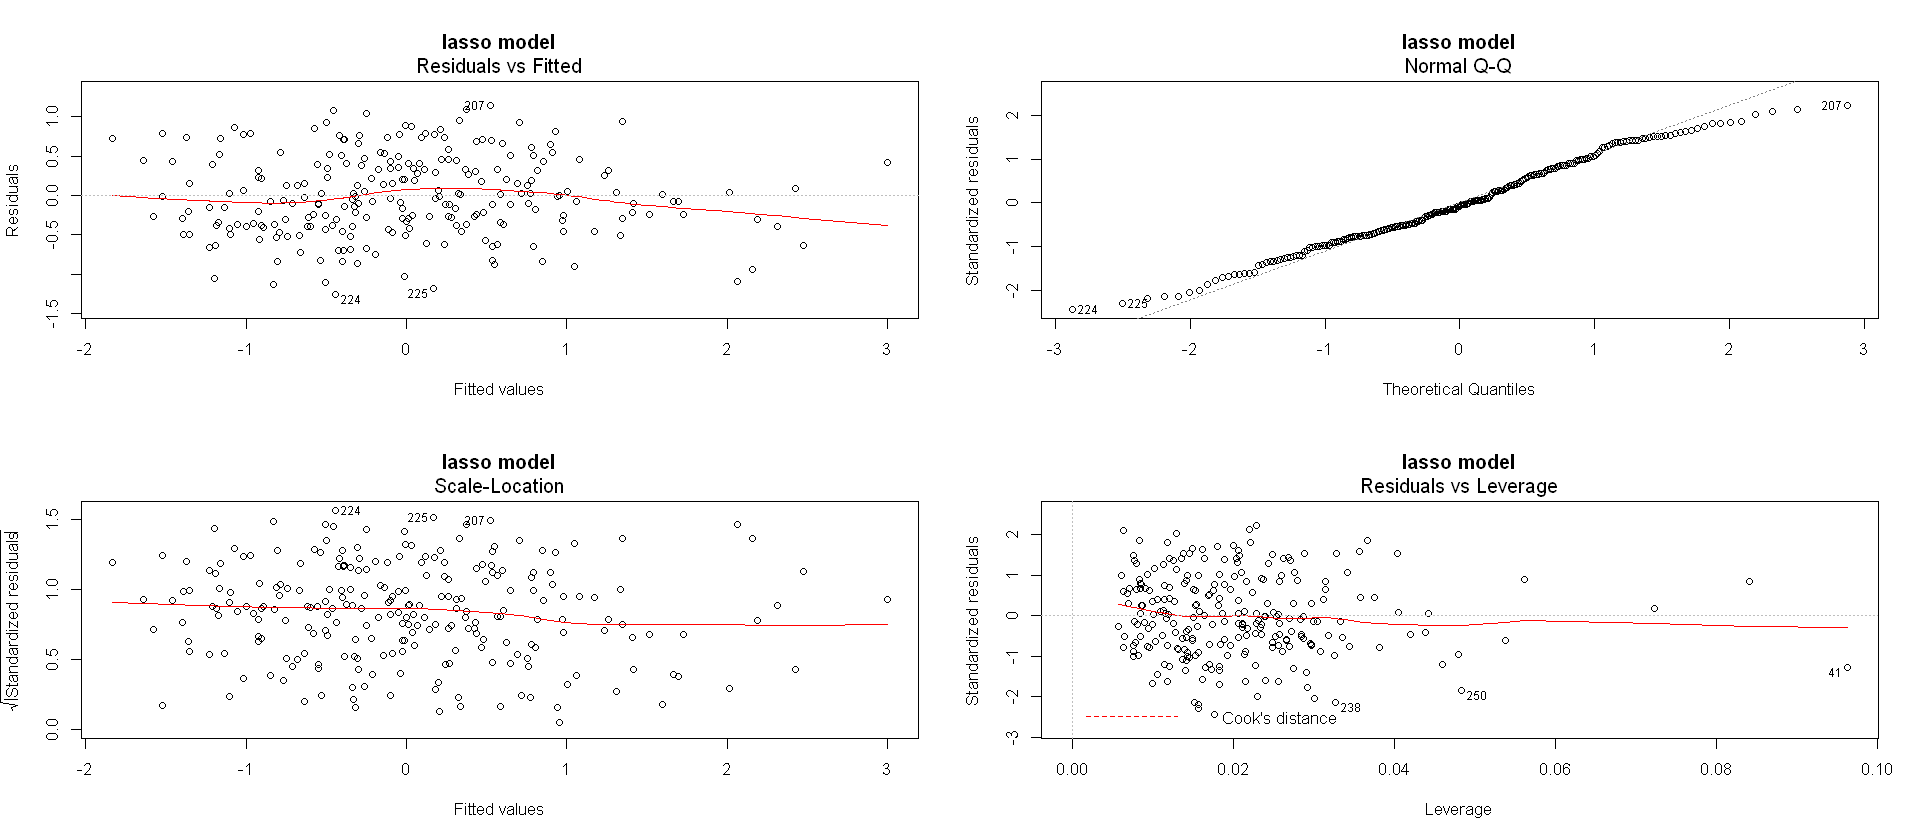

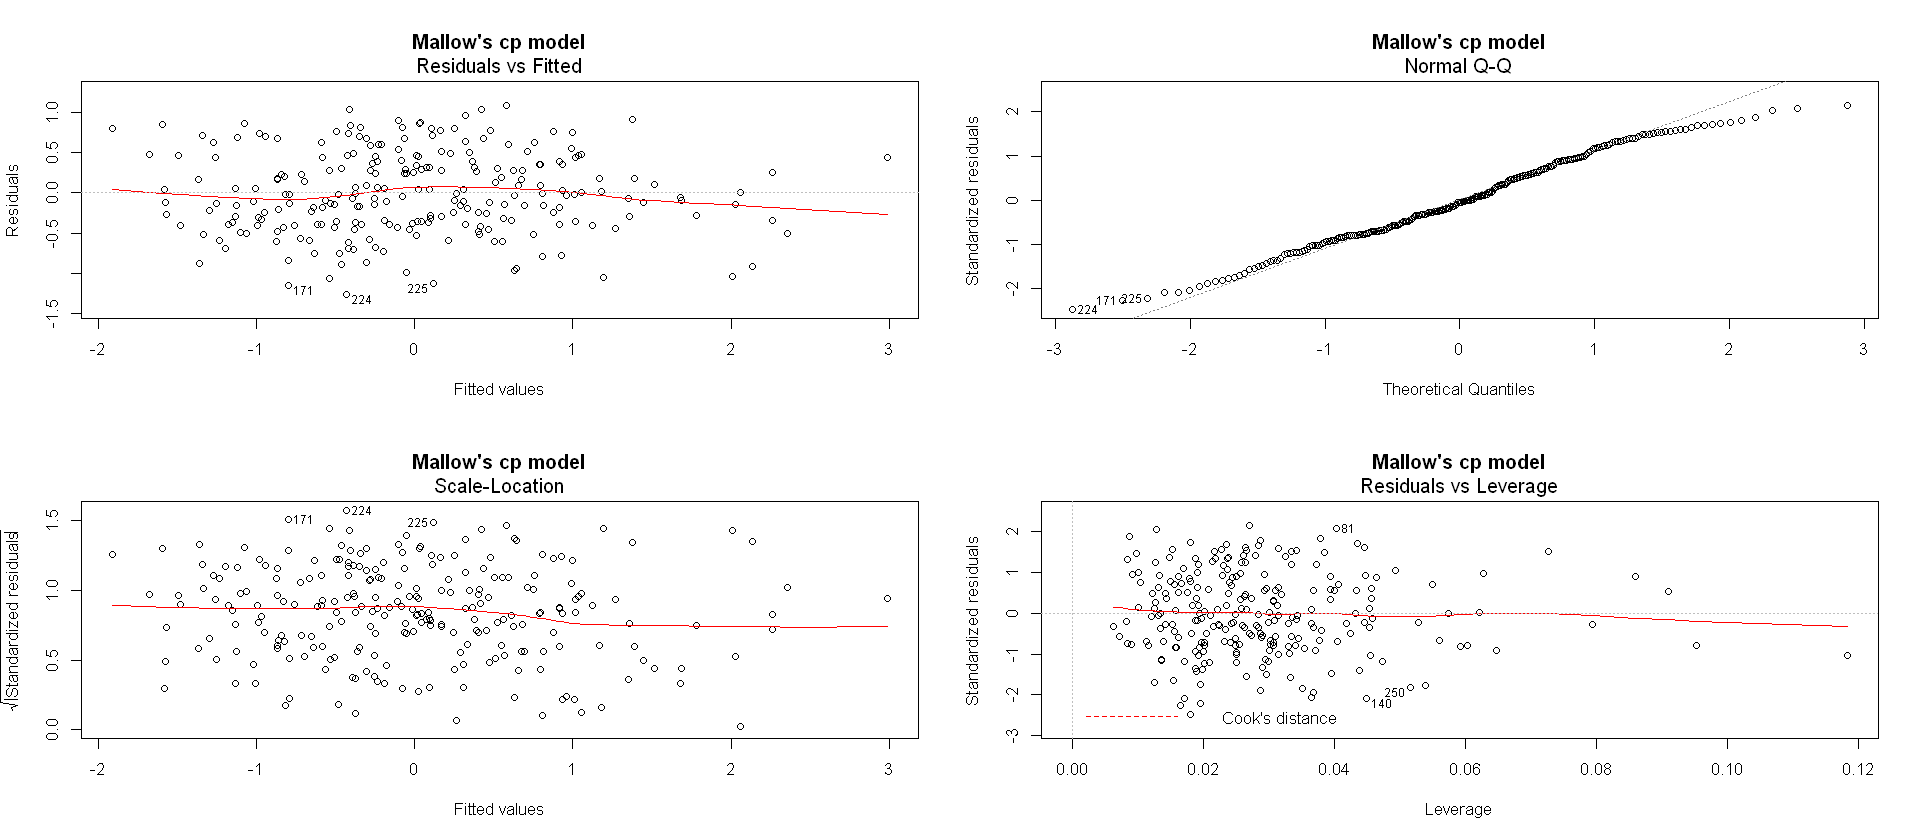

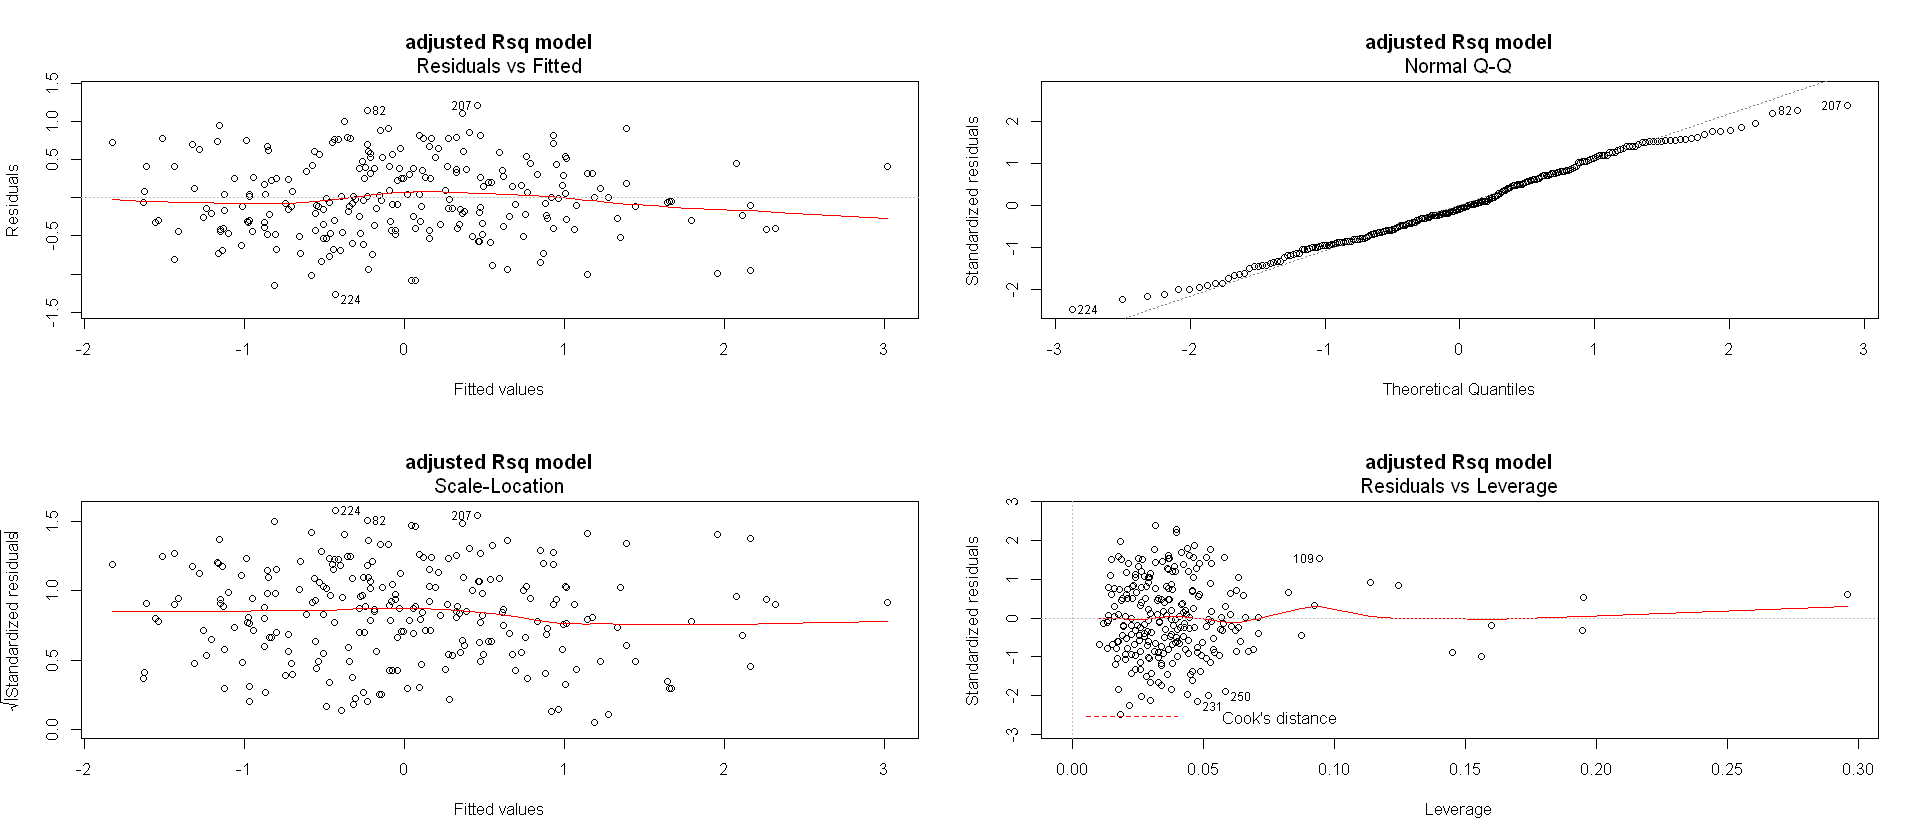

In [16]:
layout(matrix(1:4, byrow = TRUE, nrow = 2))
plot(model_AIC_b,main="backward AIC")
plot(model_AIC_f,main="forward AIC")
plot(model_AIC_t,main="both sided AIC")
plot(model_BIC_b,main="backward BIC")
plot(model_BIC_f,main="forward BIC")
plot(model_BIC_t,main="both sided BIC")
plot(model_l,main="lasso model")
plot(cp_lm,main="Mallow's cp model")
plot(adr_model,main="adjusted Rsq model")

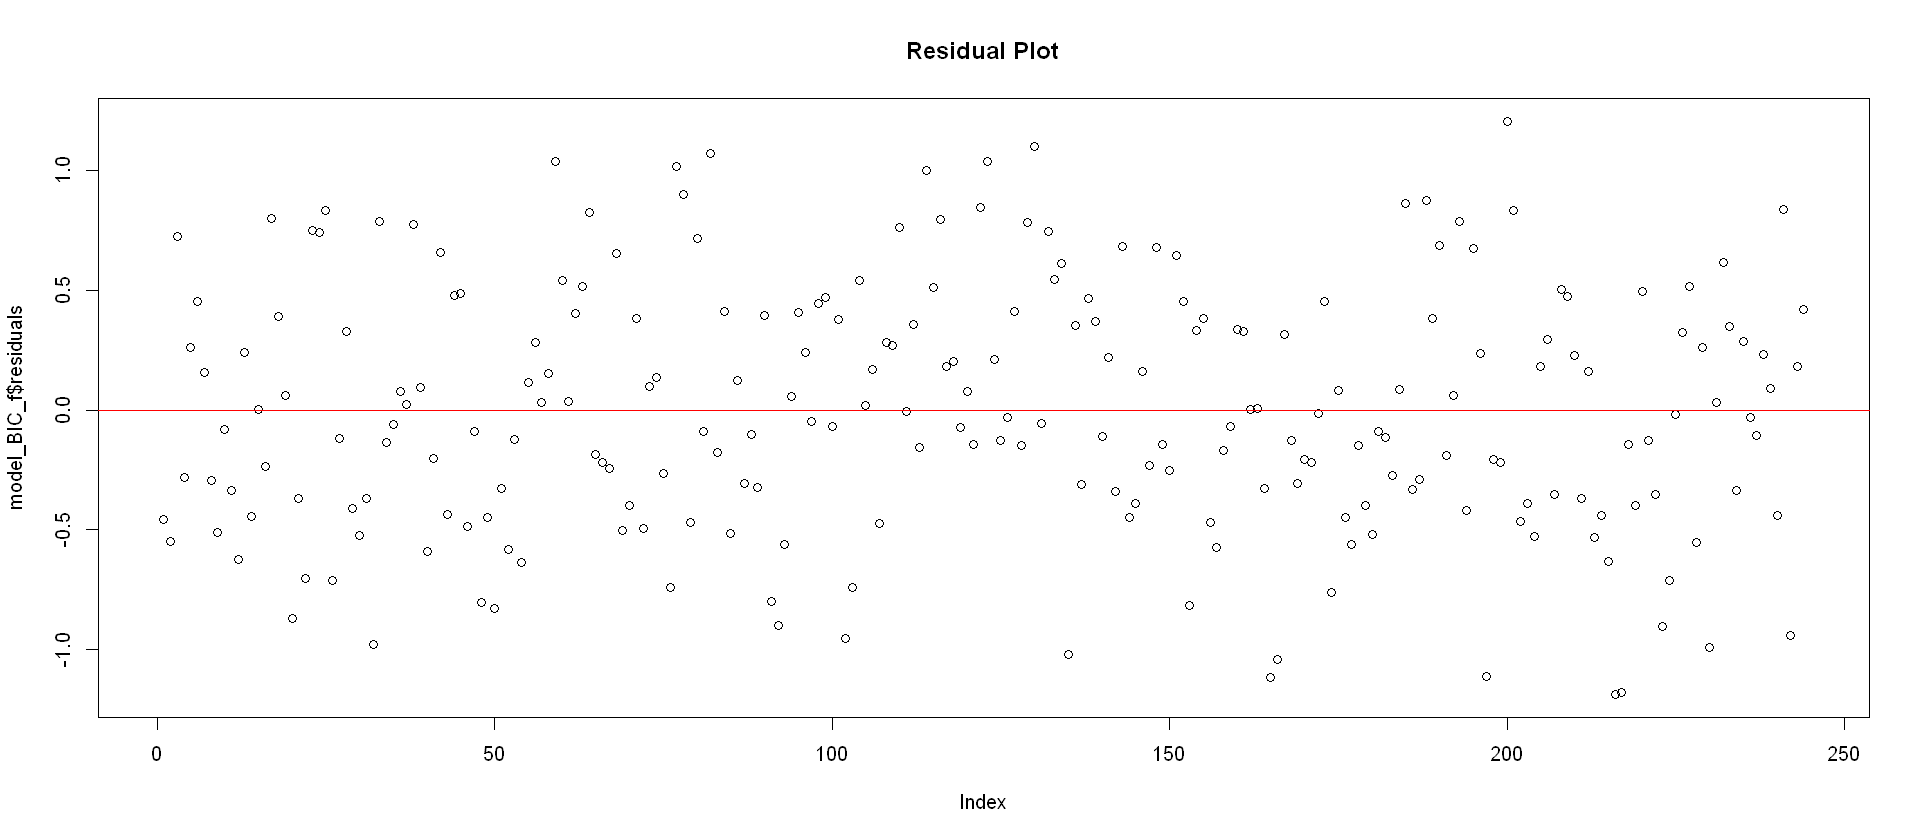

In [17]:
plot(model_BIC_f$residuals,main="Residual Plot")
abline(h=0,col="red")

### According to the model selection steps above, it seems that *abdomen, weight and wrist* are three most important predictors. By "rule of thumb" we can choose our predictors bamong them. Now check the possible multicolinearity betweeen abdomen, wrist and  weight. We create cleaned data that are not scaled again

In [19]:
new_data_clean = data_clean

In [20]:
cor(new_data_clean$WRIST,new_data_clean$ABDOMEN)
cor(new_data_clean$WEIGHT,new_data_clean$ABDOMEN)
cor(new_data_clean$WRIST,new_data_clean$WEIGHT)
vif(lm(BODYFAT ~ ABDOMEN + WEIGHT + WRIST, data = new_data_clean))
vif(lm(BODYFAT ~ ABDOMEN + WEIGHT, data = new_data_clean))
vif(lm(BODYFAT ~ ABDOMEN + WRIST, data = new_data_clean))

[1] 0.6030499

[1] 0.8726902

[1] 0.7268816

ABDOMEN   WEIGHT    WRIST 
4.231270 5.708738 2.138873

ABDOMEN   WEIGHT 
4.194422 4.194422

ABDOMEN   WRIST 
1.57151 1.57151

#### It seems that these predictors are correlated but can not be considered as multicollinearity.  We consider using only two variables and see the model's performence.

#### We consider using only two variables or even only one to see the model's performence-try to use only two x and check the model results

In [21]:
summary(lm(BODYFAT ~ ABDOMEN + WRIST, data = new_data_clean))
summary(lm(BODYFAT ~ ABDOMEN + WEIGHT, data = new_data_clean))


Call:
lm(formula = BODYFAT ~ ABDOMEN + WRIST, data = new_data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.23348 -0.38360 -0.02658  0.38533  1.35924 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.795e-18  3.434e-02   0.000        1    
ABDOMEN      9.680e-01  4.314e-02  22.440  < 2e-16 ***
WRIST       -2.397e-01  4.314e-02  -5.556 7.29e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5364 on 241 degrees of freedom
Multiple R-squared:  0.7146,	Adjusted R-squared:  0.7123 
F-statistic: 301.8 on 2 and 241 DF,  p-value: < 2.2e-16



Call:
lm(formula = BODYFAT ~ ABDOMEN + WEIGHT, data = new_data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.32955 -0.38032 -0.01522  0.37795  1.28846 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.221e-16  3.376e-02   0.000        1    
ABDOMEN      1.207e+00  6.929e-02  17.420  < 2e-16 ***
WEIGHT      -4.396e-01  6.929e-02  -6.344  1.1e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5274 on 241 degrees of freedom
Multiple R-squared:  0.7241,	Adjusted R-squared:  0.7218 
F-statistic: 316.3 on 2 and 241 DF,  p-value: < 2.2e-16


#### By summary table, we can see the R-square value of "ABDOMEN and WRIST" model and ABDOMEN and WEIGHT are almost the same. Also, by VIF analysis we find the VIF of "ABDOMEN and WEIGHT" model is larger than "ABDOMEN and WRIST" model.

#### So our final model should be BODYFAT ~ ABDOMEN + WRIST because it is they are two most important predictors and it can be easily measured. Then we do model diagnostics.

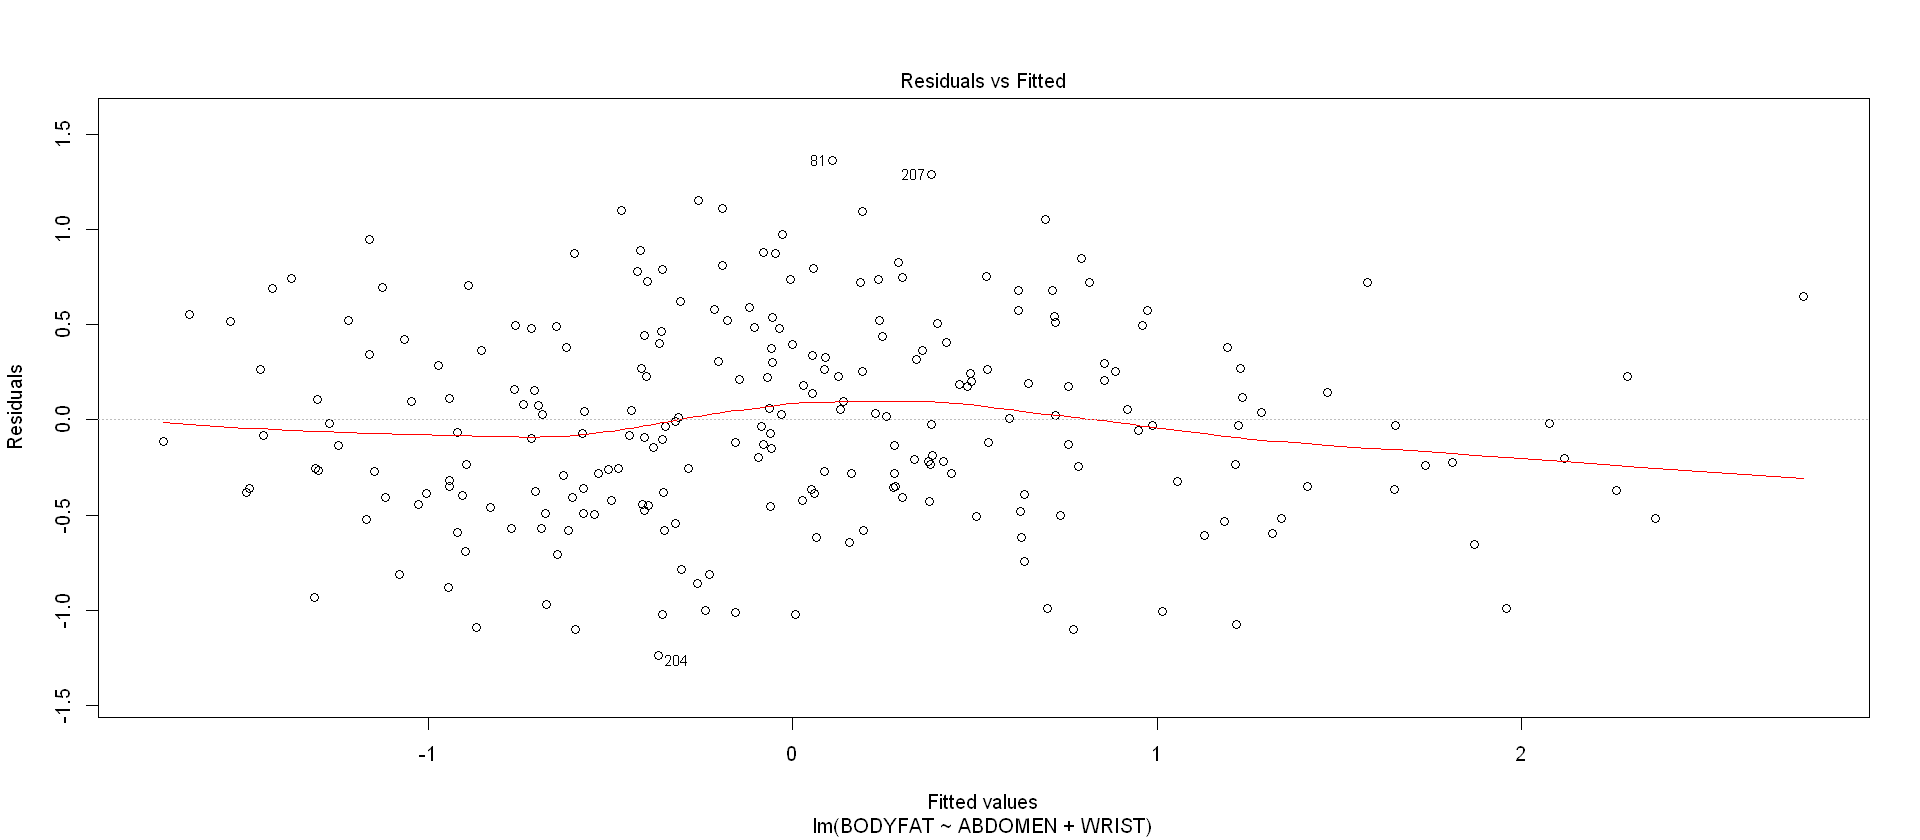

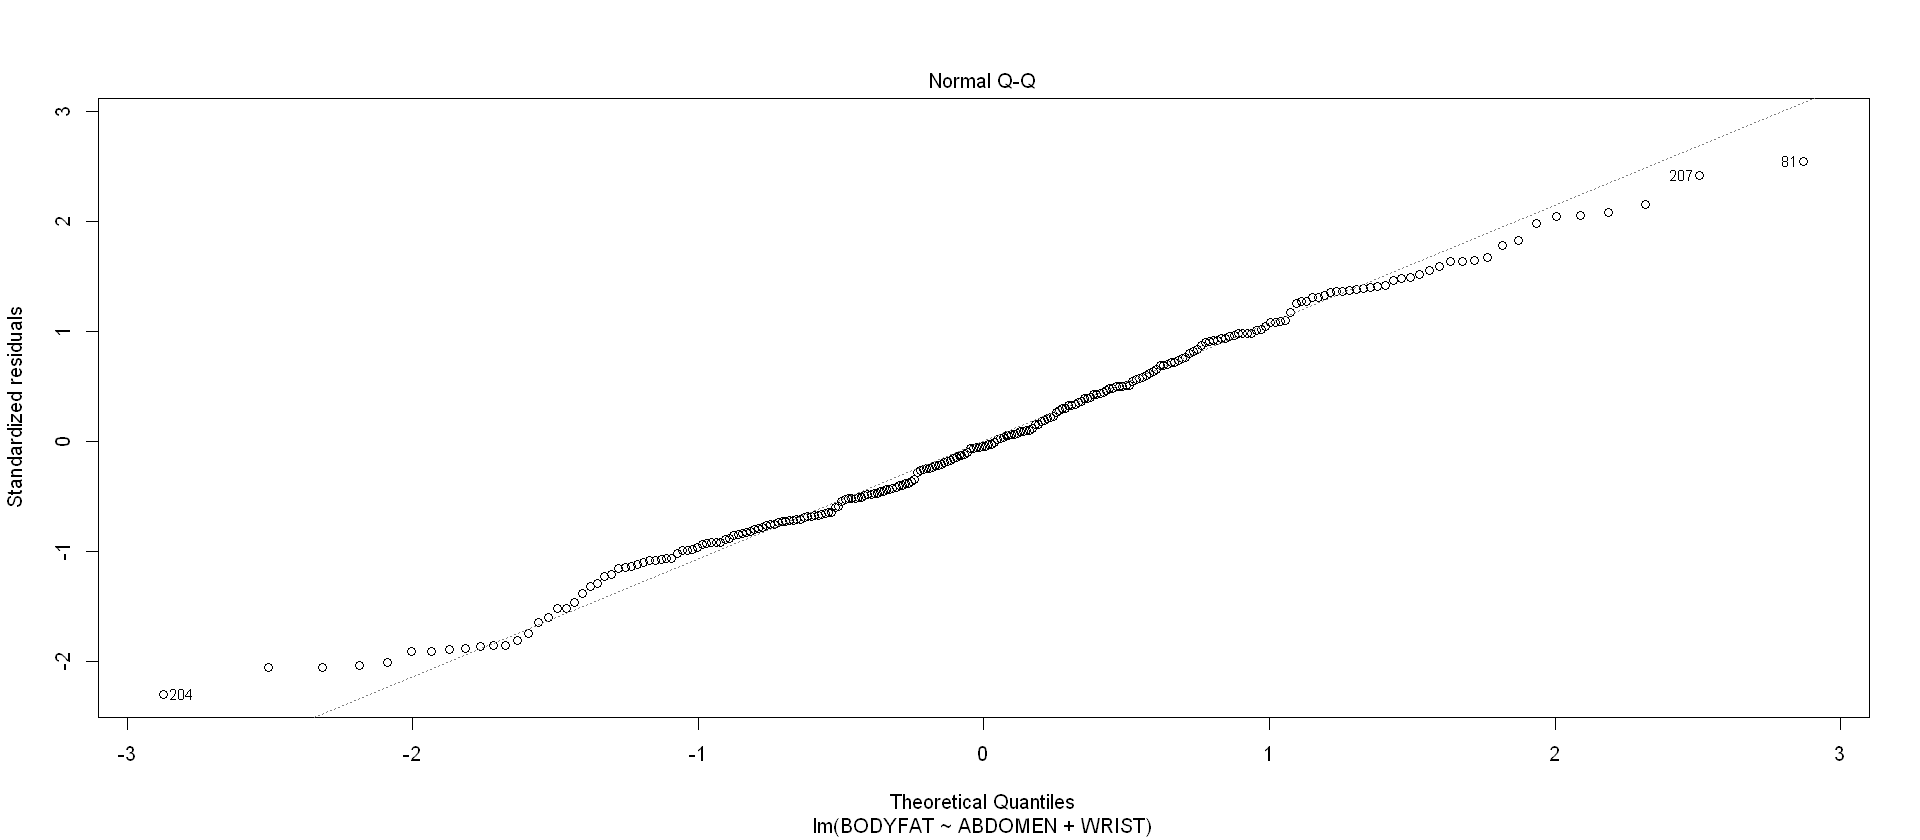

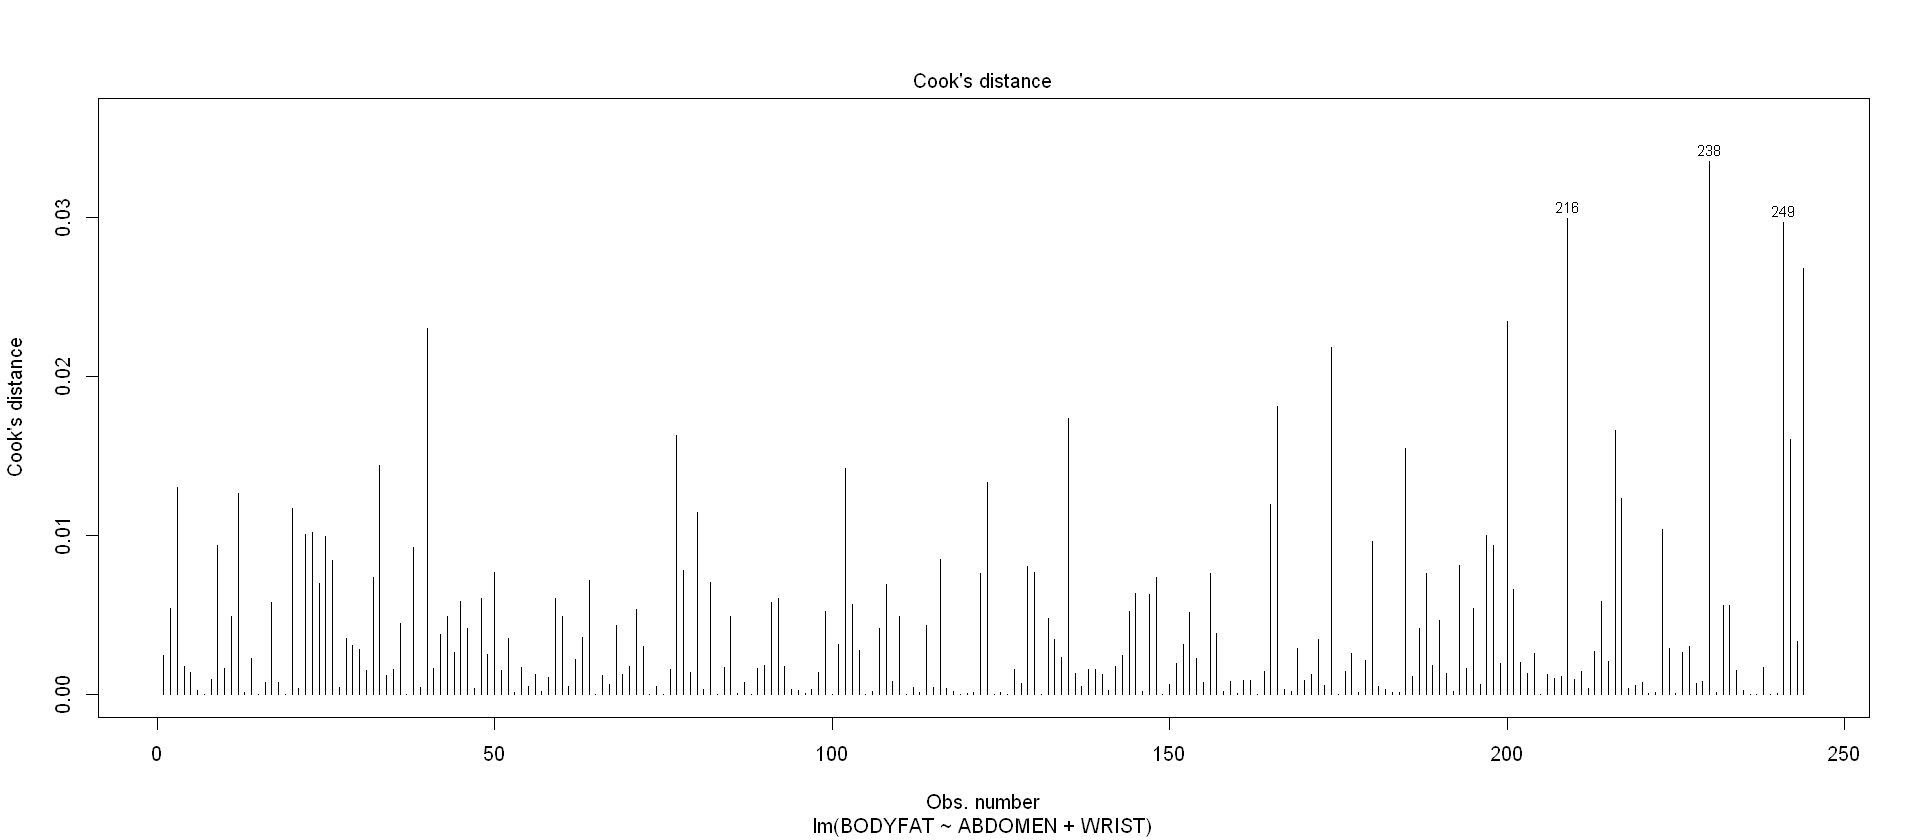

In [22]:
final_model<-lm(BODYFAT ~ ABDOMEN + WRIST, data = new_data_clean)
plot(final_model,which=1)
plot(final_model,which=2)
plot(final_model,which=4)

#### Advantages of Our Model
#### 1.Our final model is simple and straightforward. The variables included for prediction is easy to get.
#### 2.The model is robust.
#### 3.The model is accurate as the adjusted R-squared is greater than 0.6.